# Gradual ABA Semantics

Notebook to reproduce analysis and plots in the paper *"On Gradual Semantics for Assumption-based Argumentation"*

## Figure 1 - Convergence Rates and Avg Number of Steps to Converge

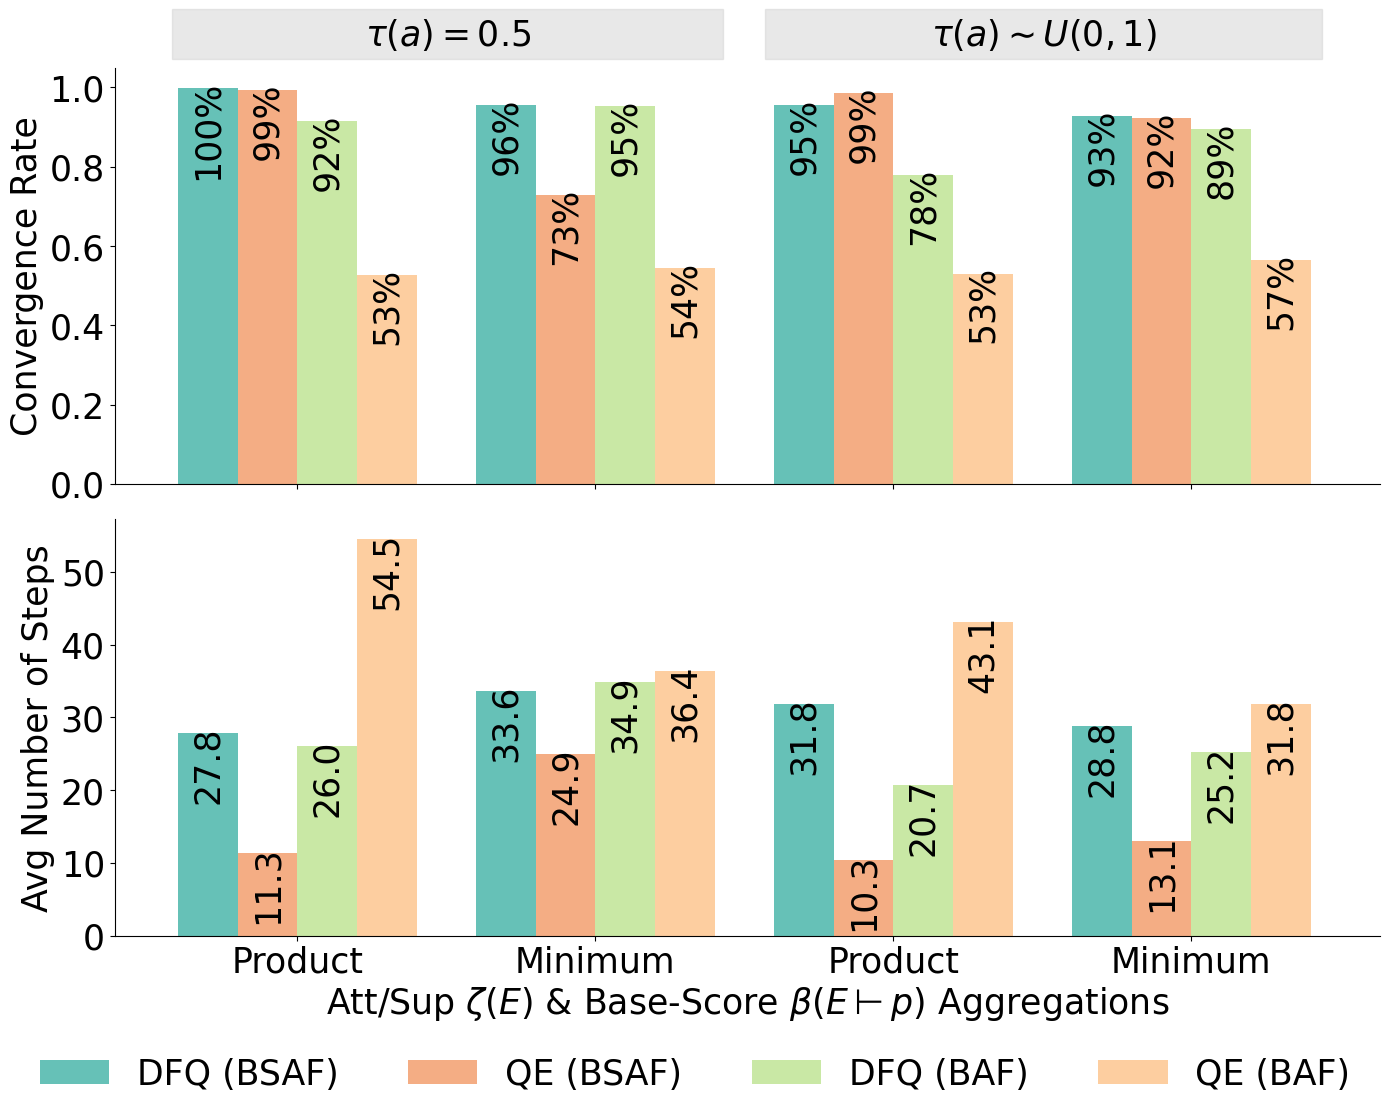

In [4]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.patches as patches

FONTSIZE = 25

# ── define files ────────────────────────────────────────────────────
# two inits × two aggs × two suffixes (BSAF vs BAF)
scenario_files = [
    ("Constant", "Product",  " (BSAF)", "convergence_results_to10m_nf_atm_e2_d5_s5000_prod.pkl"),
    ("Constant", "Minimum",  " (BSAF)", "convergence_results_to10m_nf_atm_e2_d5_s5000_min.pkl"),
    ("Constant", "Product",  " (BAF)",  "convergence_results_to10m_nf_atm_e3_d5_s5000_prod_mean.pkl"),
    ("Constant", "Minimum",  " (BAF)",  "convergence_results_to10m_nf_atm_e3_d5_s5000_min_mean.pkl"),
    ("Uniform(0,1)", "Product",  " (BSAF)", "convergence_results_to10m_nf_atm_e2_d5_s5000_randinitall_prod.pkl"),
    ("Uniform(0,1)", "Minimum",  " (BSAF)", "convergence_results_to10m_nf_atm_e2_d5_s5000_randinitall_min.pkl"),
    ("Uniform(0,1)", "Product",  " (BAF)",  "convergence_results_to10m_nf_atm_e3_d5_s5000_randinitall_prod_mean.pkl"),
    ("Uniform(0,1)", "Minimum",  " (BAF)",  "convergence_results_to10m_nf_atm_e3_d5_s5000_randinitall_min_mean.pkl"),
]


def annotate_tau_regions(ax,
                         spans,
                         labels,
                         y_base=1.02,
                         height=0.10,
                         facecolor="lightgrey",
                         alpha=0.5,
                         fontsize=25):
    """
    Draw shaded “column” boxes spanning each (xmin,xmax) in data coords,
    between y_base and y_base+height in axis‐fraction coords,
    and center the given labels inside them.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axis on which you drew your bars (e.g. ax_r).
    spans : list of (xmin, xmax)
        X‐ranges in data units over which to draw each box.
    labels : list of str
        Text labels to center in each box.
    y_base : float
        The bottom of each box, in axis‐fraction coords (0=bottom, 1=top).
    height : float
        The height of each box, in axis‐fraction coords.
    facecolor : str
        Box fill color.
    alpha : float
        Box transparency.
    fontsize : int
        Font size for the τ labels.
    """
    for (xmin, xmax), txt in zip(spans, labels):
        # draw the vertical span
        ax.axvspan(xmin,
                   xmax,
                   ymin=y_base,
                   ymax=y_base + height,
                   color=facecolor,
                   alpha=alpha,
                   clip_on=False)

        # now place the text in the center of that span
        ax.text(
            (xmin + xmax) / 2,           # center in data‐x
            (y_base + (y_base + height)) / 2,  # center in axis‐fraction‐y
            txt,
            transform=ax.get_xaxis_transform(),  # x in data, y in axis‐fraction
            ha="center",
            va="center",
            fontsize=fontsize
        )
# loader: compute per-model rate & time, then remap names based on suffix
def load_overall_stats(path, suffix=""):
    runs = pickle.load(open(path, "rb"))
    good = [r for r in runs if not r.get("timeout", False)]
    by_model = defaultdict(list)
    for r in good:
        name = " ".join(r["model"].split())
        by_model[name].append(r)

    stats = {}
    for model, runs in by_model.items():
        N = len(runs)
        conv_count = sum(r.get("global_converged", False) for r in runs)
        rate = conv_count / N if N else 0.0
        times = []
        for r in runs:
            ct = r.get("convergence_time")
            if isinstance(ct, dict):
                vals = [v for v in ct.values() if v is not None]
                if vals:
                    times.append(sum(vals)/len(vals))
            elif isinstance(ct, (int, float)):
                times.append(ct)
        mean_t = sum(times)/len(times) if times else 0.0
        stats[model] = (rate, mean_t)

    # remap base models for BSAF and BAF suffix
    if suffix == " (BSAF)":
        new = {}
        for m, (r, t) in stats.items():
            # skip any already BAF
            if not m.endswith("(BAF)"):
                new[f"{m}{suffix}"] = (r, t)
        stats = new
    elif suffix == " (BAF)":
        new = {}
        for m, (r, t) in stats.items():
            if m.endswith("(BAF)"):
                base = m[:-len("(BAF)")].strip()
                new[f"{base}{suffix}"] = (r, t)
        stats = new

    return stats

# load all
raw = {}
for init, agg, suf, path in scenario_files:
    raw[(init, agg, suf)] = load_overall_stats(path, suf)

# models to plot (four variants)
models = ["DF-QuAD (BSAF)", "QE (BSAF)", "DF-QuAD (BAF)", "QE (BAF)"]
inits = ["Constant", "Uniform(0,1)"]
aggs = ["Product", "Minimum"]

# build arrays
conv_rates = {(i,a): [] for i in inits for a in aggs}
conv_times = {(i,a): [] for i in inits for a in aggs}
for i in inits:
    for a in aggs:
        for m in models:
            suffix = " (BAF)" if "(BAF)" in m else " (BSAF)"
            r, t = raw[(i, a, suffix)].get(m, (0.0, 0.0))
            conv_rates[(i,a)].append(r)
            conv_times[(i,a)].append(t)

# plot
n = len(models)
width = 0.8/n
x = np.arange(len(inits)*len(aggs))
colors = {
    'DF-QuAD (BSAF)': "#009988",
    'QE (BSAF)':      "#EE7733",
    'DF-QuAD (BAF)':  "#A6D96A",
    'QE (BAF)':       "#FDAE61",
}

fig, (ax_r, ax_t) = plt.subplots(2,1, figsize=(14,12), sharex=True)
for idx, m in enumerate(models):
    off = (idx - (n-1)/2) * width
    rates = [conv_rates[(i,a)][idx] for i in inits for a in aggs]
    times = [conv_times[(i,a)][idx] for i in inits for a in aggs]
    ax_r.bar(x+off, rates, width, color=colors[m], label=m, alpha=0.6)
    ax_t.bar(x+off, times, width, color=colors[m], label=m, alpha=0.6)
    for xi, v in zip(x, rates): ax_r.text(xi+off, v+0.02, f"{100*v:.0f}%", ha="center", va="top", fontsize=FONTSIZE, rotation=90)
    for xi, v in zip(x, times): ax_t.text(xi+off, v+1, f"{v:.1f}", ha="center", va="top", fontsize=FONTSIZE, rotation=90)

# axes
ax_r.set_ylabel("Convergence Rate", fontsize=FONTSIZE); ax_r.set_ylim(0,1.05)
for s in ['top','right']: ax_r.spines[s].set_visible(False)

ax_t.set_ylabel("Avg Number of Steps", fontsize=FONTSIZE)
ax_t.set_xticks(x)
ax_t.set_xticklabels(aggs * len(inits), fontsize=FONTSIZE)
ax_t.set_xlabel(r"Att/Sup $\zeta(E)$ & Base-Score $\beta(E\vdash p)$ Aggregations", fontsize=FONTSIZE)
for s in ['top','right']: ax_t.spines[s].set_visible(False)

## set all axes fonts to FONTSIZE
for ax in [ax_r, ax_t]:
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FONTSIZE)

# legend below
h, l = ax_t.get_legend_handles_labels()
l = [lab.replace("DF-QuAD","DFQ") for lab in l]
fig.legend(h, l, loc='upper center', ncol=4, frameon=False, bbox_to_anchor=(0.5,0.06), fontsize=FONTSIZE)

# headers
# fig.text(0.3,0.90, r"$\tau=0.5$", ha='center', va='bottom', fontsize=FONTSIZE)
# fig.text(0.75,0.90, r"$\tau=U(0,1)$", ha='center', va='bottom', fontsize=FONTSIZE)
# define the x‐ranges that cover your two scenarios:
# spans for the two τ scenarios:
region_spans = [
    (-0.42, 1.43),   # covers the Constant (Product & Minimum)
    ( 1.57, 3.44),   # covers the Uniform(0,1) (Product & Minimum)
]
labels = [r"$\tau(a)=0.5$", r"$\tau(a)\sim U(0,1)$"]

# tweak y_base up or down, and height to make your boxes taller/thinner:
annotate_tau_regions(ax_r,
                     region_spans,
                     labels,
                     y_base=1.02,     # bottom of box just above y=1.0
                     height=0.12,     # 12% of the axes height
                     facecolor="lightgrey",
                     alpha=0.5,
                     fontsize=FONTSIZE)
plt.tight_layout(rect=[0,0.05,1,0.92])
plt.show()



## Figure 2 - DfQ and QE by ABAF features

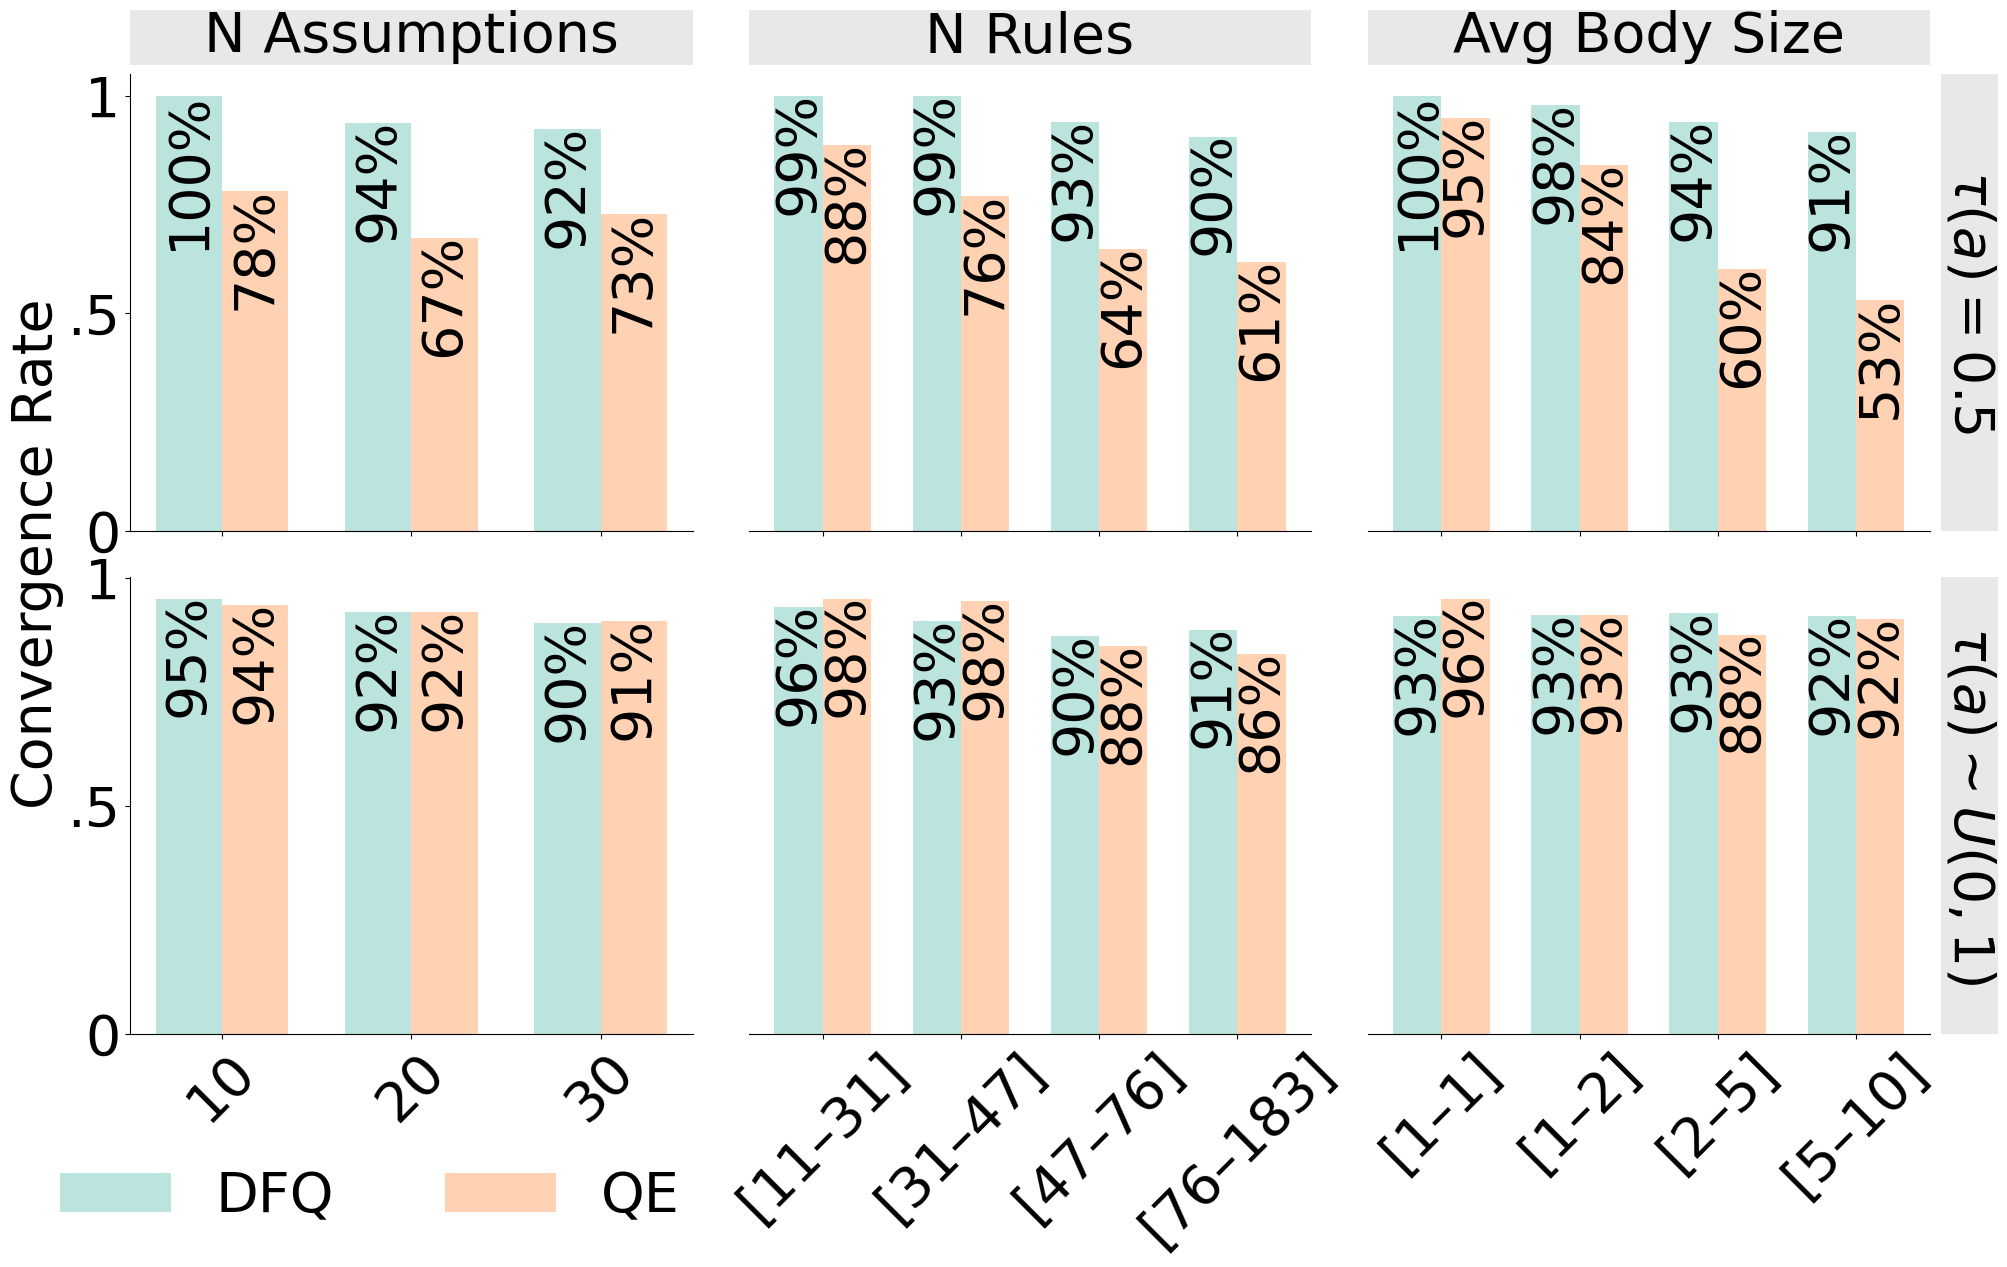

In [5]:
# Updated plotting function with requested changes

import warnings
import pickle
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
import matplotlib.patches as patches

# ── CONFIG ────────────────────────────────────────────────────────────────
ABA_FOLDER = Path("../data_generation/abaf/")
SCENARIOS = [
    ("SetMin – Fixed",      "convergence_results_to10m_nf_atm_e2_d5_s5000_min.pkl"),
    ("SetMin – Random",     "convergence_results_to10m_nf_atm_e2_d5_s5000_randinitall_min.pkl"),
]
META_COLS = ["num_assumptions_file", "num_rules_file", "avg_body_size_file"]
COL_DISPLAY = {
    "num_assumptions_file": "N Assumptions",
    "num_rules_file":       "N Rules",
    "avg_body_size_file":   "Avg Body Size"
}
Q = 4
FONTSIZE = 40

# build metadata
def build_file_meta(folder):
    rec = {}
    for p in sorted(folder.glob("*.aba")):
        lines   = p.read_text().splitlines()
        assumps = [ln for ln in lines if ln.startswith("a ")]
        rules   = [ln for ln in lines if ln.startswith("r ")]
        bodies  = [ln.split()[2:] for ln in rules]
        rec[p.stem] = {
            "num_assumptions_file": len(assumps),
            "num_rules_file":       len(rules),
            "avg_body_size_file":   (sum(len(b) for b in bodies)/len(bodies)) if bodies else 0.0,
        }
    return pd.DataFrame.from_dict(rec, orient="index")

meta = build_file_meta(ABA_FOLDER)

# safe average of convergence_time dict (no empty‐slice warnings)
def _avg_time(ct):
    if isinstance(ct, dict):
        vals = [v for v in ct.values() if v is not None]
        return sum(vals) / len(vals) if vals else 0.0
    elif isinstance(ct, (int, float)):
        return ct
    else:
        return 0.0

# load scenarios
frames = []
for label, pkl in SCENARIOS:
    runs = pickle.load(open(pkl, "rb"))
    df = pd.DataFrame(runs)
    df = df[df["timeout"] == False].copy()
    df["stem"] = df["file"].str.replace(r"\.aba$", "", regex=True)
    df = df.merge(meta, left_on="stem", right_index=True, how="left")
    df["conv_time_avg"] = df["convergence_time"].apply(_avg_time)

    df["scenario"] = label
    frames.append(df)
all_df = pd.concat(frames, ignore_index=True)

# bucket metadata columns
for col in META_COLS:
    n_unique = all_df[col].nunique()
    bucket_col = col + "_bucket"
    if n_unique <= Q:
        all_df[bucket_col] = all_df[col].astype(str)
    else:
        all_df[bucket_col] = pd.qcut(all_df[col], q=min(Q, n_unique), duplicates="drop")


# safe average of convergence_time dict (no empty‐slice warnings)
def _avg_time(ct):
    if isinstance(ct, dict):
        vals = [v for v in ct.values() if v is not None]
        return sum(vals) / len(vals) if vals else 0.0
    elif isinstance(ct, (int, float)):
        return ct
    else:
        return 0.0

def plot_metric(metric, title, ylabel, fmt_tick):
    n_row, n_col = len(SCENARIOS), len(META_COLS)
    fig, axes = plt.subplots(n_row, n_col,
                             figsize=(8*n_col, 6*n_row),
                             sharey=False)
    # leave space at top/right for our boxes
    fig.subplots_adjust(left=0.15, right=0.90, top=0.85, bottom=0.05)

    legend_handles = legend_labels = None

    # 1) Draw each small multiple of bars
    for i, (scenario, _) in enumerate(SCENARIOS):
        sub = all_df[all_df["scenario"] == scenario]
        for j, col in enumerate(META_COLS):
            ax = axes[i][j]
            bucket_col = col + "_bucket"

            # --- your existing grouping & pivot logic ---
            dtype = sub[bucket_col].dtype
            if isinstance(dtype, CategoricalDtype):
                cats = sub[bucket_col].cat.categories
                labels_x = [f"[{int(iv.left)}–{int(iv.right)}]" for iv in cats]
            else:
                cats = sorted(sub[bucket_col].unique())
                labels_x = [str(c) for c in cats]

            # 1) group with observed=False
            grp = (
                sub
                .groupby([bucket_col, "model"], observed=False)
                .agg(
                    runs          = ("timeout",        "count"),
                    n_converged   = ("global_converged","sum"),
                    conv_time_avg = ("conv_time_avg",  "mean"),
                )
            )

            # 2) unstack & fillna, but silence the FutureWarning about downcasting
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", FutureWarning)
                tmp = grp.unstack("model").fillna(0)

            # 3) re‐infer numeric dtypes (optional, tmp is already numeric)
            piv = tmp.infer_objects()

            if metric == "rate":
                vals = (piv["n_converged"] / piv["runs"]).reindex(cats)
            else:
                vals = piv["conv_time_avg"].reindex(cats)

            # shorten names
            vals = vals.rename(columns=lambda s: s.replace(" (BSAF)","").replace(" (BAF)",""))

            qad = vals["DF-QuAD"].values
            qe  = vals["QE"].values

            teal, orange = "#8dd3c7", "#ffb482"
            x = np.arange(len(cats))
            w = 0.35
            b1 = ax.bar(x - w/2, qad, w, label="DfQ", alpha=0.6, color=teal)
            b2 = ax.bar(x + w/2, qe,  w, label="QE",  alpha=0.6, color=orange)

            # value annotations
            for xi in x:
                ax.text(xi - w/2, qad[xi] + 0.01, fmt_tick(qad[xi]),
                        ha="center", va="top", fontsize=FONTSIZE, rotation=90)
                ax.text(xi + w/2, qe[xi]  + 0.01, fmt_tick(qe[xi]),
                        ha="center", va="top", fontsize=FONTSIZE, rotation=90)

            # x‐axis
            ax.set_xticks(x)
            if i == n_row-1:
                ax.set_xticklabels(labels_x, fontsize=FONTSIZE, rotation=45)
            else:
                ax.set_xticklabels([])

            # y‐axis
            ax.tick_params(axis='y', labelsize=FONTSIZE)
            if j == 0:
                # ax.set_ylabel(ylabel, fontsize=FONTSIZE)
                if metric == "rate":
                    ax.set_yticks([0,0.5,1])
                    ax.set_yticklabels(["0",".5","1"])
            else:
                ax.yaxis.set_visible(False)
                ax.spines['left'].set_visible(False)

            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            # capture legend once
            if legend_handles is None and i == 0 and j == n_col-1:
                legend_handles = [b1, b2]
                legend_labels  = ["DFQ","QE"]

    # 2) Draw three grey header boxes above each column (in axis coords)
    box_y      = 1.00 + 0.02   # bottom of the box, in axis‐fraction (just above the top of the plot)
    box_height = 0.12          # height of the box (12% of the axis height)
    for j in range(n_col):
        ax_top = axes[0][j]
        # draw the rectangle
        ax_top.add_patch(
            patches.Rectangle(
                (0, box_y),        # x0= left edge, y0=box_y
                1,                  # width = full axis width
                box_height,         # height = box_height
                transform=ax_top.transAxes,
                facecolor="lightgrey",
                edgecolor="none",
                alpha=0.5,
                clip_on=False
            )
        )
        # center the column title in that box
        ax_top.text(
            0.5,                     # center in x
            box_y + box_height/2,    # center in y
            COL_DISPLAY[META_COLS[j]],
            transform=ax_top.transAxes,
            ha='center', va='center',
            fontsize=FONTSIZE
        )

    # 3) Draw two grey side bars (one per row) to the right of the last column
    side_x      = 1.02   # left edge, in axis‐fraction (just to the right of plot)
    side_width  = 0.1   # how wide the bar is (in axis‐fraction)
    side_y      = 0.  # bottom of the bar (in axis‐fraction)
    side_height = 1   # height of the bar (in axis‐fraction)

    for i in range(n_row):
        ax_side = axes[i][-1]
        # draw the grey rectangle
        ax_side.add_patch(
            patches.Rectangle(
                (side_x, side_y),
                side_width,
                side_height,
                transform=ax_side.transAxes,
                facecolor="lightgrey",
                edgecolor="none",
                alpha=0.5,
                clip_on=False
            )
        )
        # re‐position the τ text in the center of that rectangle
        label = r"$\tau(a)=0.5$" if i == 0 else r"$\tau(a)\sim U(0,1)$"
        ax_side.text(
            side_x + side_width/2,
            side_y + side_height/2,
            label,
            transform=ax_side.transAxes,
            ha='center',
            va='center',
            rotation=-90,
            fontsize=FONTSIZE
        )

    # 4) Legend & super‐title & show
    fig.legend(legend_handles, legend_labels,
               loc="lower left", bbox_to_anchor=(0.1,-0.15),
               frameon=False, fontsize=FONTSIZE, ncol=2)
    fig.suptitle(title, y=0.97, fontsize=FONTSIZE)
    fig.supylabel(ylabel, fontsize=FONTSIZE, x=0.1, y=0.45)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.show()




# draw the two plots
plot_metric(
    metric="rate",
    title="",
    ylabel="Convergence Rate",
    fmt_tick=lambda v: f"{100*v:.0f}%"
)
# plot_metric(
#     metric="time",
#     title="",
#     ylabel="Avg Steps to Converge",
#     fmt_tick=lambda v: f"{v:.1f}"
# )




## Figure 3 - Run Single ABAFs and plot trajectories

Analysing rules: 100%|██████████| 157/157 [00:00<00:00, 2490.94it/s]


0.46s to build 10388 arguments


Analysing rules: 100%|██████████| 56/56 [00:05<00:00, 11.19it/s]


19.82s to build 2794 arguments


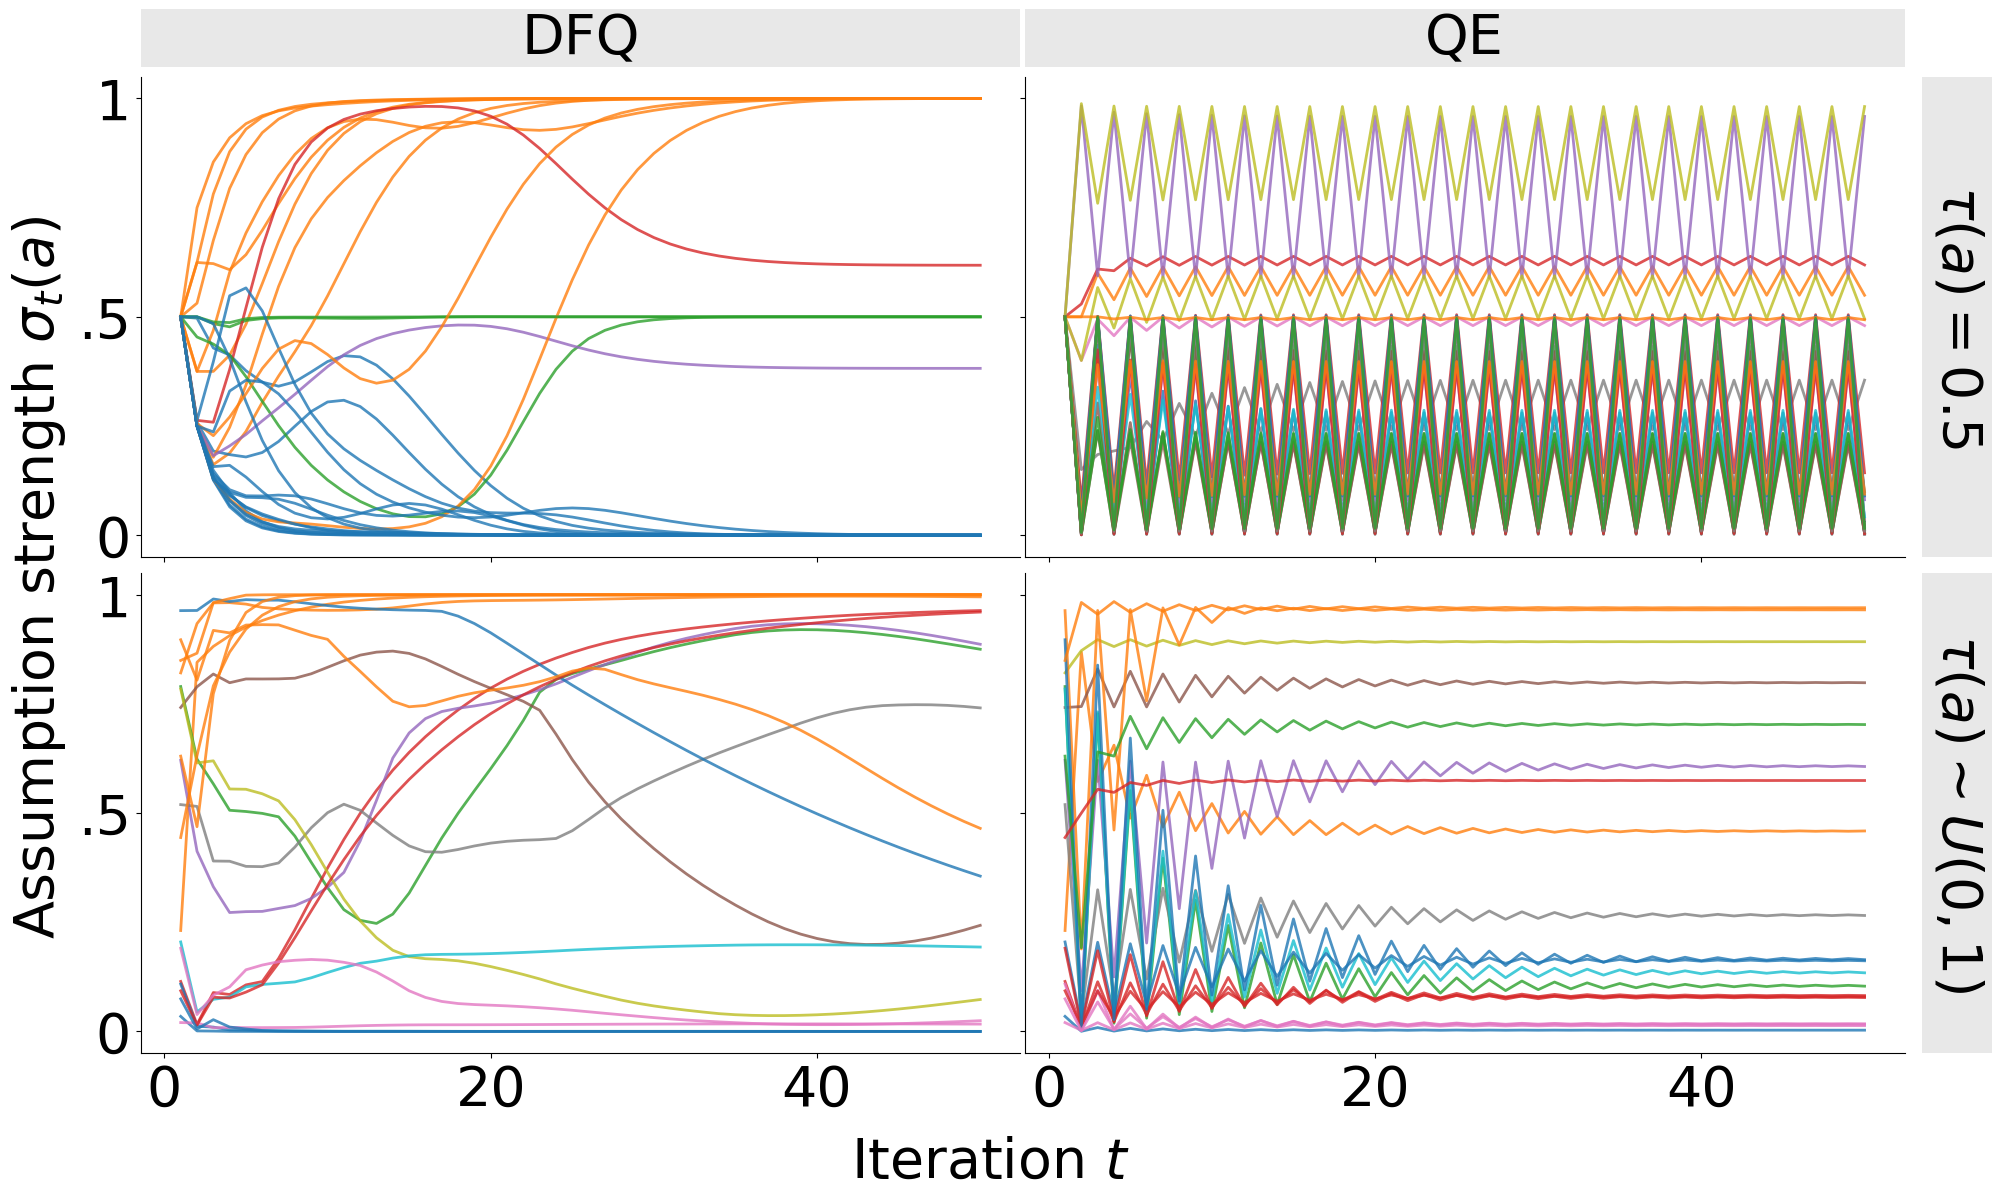

In [6]:
import sys
import matplotlib.pyplot as plt
import random
sys.path.append("../")

from ABAF import ABAF
from semantics.bsafDiscreteModular import DiscreteModular
from semantics.modular.ProductAggregation      import ProductAggregation
from semantics.modular.SumAggregation          import SumAggregation
from semantics.modular.SetProductAggregation   import SetProductAggregation
from semantics.modular.SetMinAggregation      import SetMinAggregation
from semantics.modular.LinearInfluence         import LinearInfluence
from semantics.modular.QuadraticMaximumInfluence import QuadraticMaximumInfluence

# streamlined strengthplot1: no per-panel labels, grouped colors, small fonts

FONTSIZE = 40

def strengthplot1(
    model,
    delta,
    epsilon,
    ax
):
    graph_data = getattr(model, "graph_data",
                         getattr(model, "approximator", {})
                            .get("graph_data", None))
    if not graph_data:
        raise ValueError("Call solve(..., generate_plot=True) first to populate graph_data")

    # cluster by last delta values for coloring
    cmap = plt.get_cmap("tab10")
    series_tail = {}
    for name, seq in graph_data.items():
        tail = seq[-delta:] if len(seq) >= delta else seq
        series_tail[name] = [v for _, v in tail]

    clusters = []
    for name, vals in series_tail.items():
        placed = False
        for cluster in clusters:
            rep = series_tail[cluster[0]]
            if max(abs(a-b) for a,b in zip(vals, rep)) <= epsilon:
                cluster.append(name)
                placed = True
                break
        if not placed:
            clusters.append([name])

    name2color = {}
    for idx, cluster in enumerate(clusters):
        color = cmap(idx % 10)
        for nm in cluster:
            name2color[nm] = color

    # plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for name, seq in graph_data.items():
        xs = [t for t,_ in seq]
        ys = [v for _,v in seq]
        ax.plot(xs, ys, lw=2, alpha=0.8, color=name2color[name])

    # stylistic tweaks
    ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)
    ax.set_yticks([0,0.5,1])
    ax.set_yticklabels(["0",".5","1"])
    ax.xaxis.labelpad = 0    # no padding below x-axis label
    ax.yaxis.labelpad = 0    # no padding beside y-axis label
    ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)

# === main script: 2×2 grid ===
EPSILON    = 1e-2
DELTA      = 5
TIME_STEPS = 50

file_paths = [
    "../data_generation/abaf/nf_atm_s60_n0.2_a0.5_r8_b2_4.aba",
    "../data_generation/abaf/nf_atm_s40_n0.2_a0.5_r4_b8_0.aba"
]
file_count = 0
# prepare solved models per file
results = []
for path in file_paths:
    file_count += 1
    if file_count == 1:
        agg_f = SetProductAggregation()
        BASE_SCORES = ''
    else:
        agg_f = SetMinAggregation()
        BASE_SCORES = "random"

    abaf = ABAF(path=str(path), weight_fn=(lambda: random.uniform(0.0, 1.0)) if BASE_SCORES == "random" else None)
    bsaf = abaf.to_bsaf(weight_agg=agg_f)

    # two semantics
    m1 = DiscreteModular(
        BSAF            = bsaf,
        aggregation     = ProductAggregation(),
        influence       = LinearInfluence(conservativeness=1),
        set_aggregation = agg_f
    )
    m2 = DiscreteModular(
        BSAF            = bsaf,
        aggregation     = SumAggregation(),
        influence       = QuadraticMaximumInfluence(conservativeness=1),
        set_aggregation = agg_f
    )
    # solve
    for m in (m1,m2):
        m.solve(TIME_STEPS, generate_plot=True, verbose=False)
    results.append((m1,m2))

# create 2×2 figure
fig, axes = plt.subplots(
    nrows=2, ncols=2,
    figsize=(20, 12),
    sharex=True, sharey=True
)

# labels for columns
col_labels = ["DFQ", "QE"]
# plot each

for i, (m1, m2) in enumerate(results):
    for j, model in enumerate((m1, m2)):
        ax = axes[i][j]
        strengthplot1(model, DELTA, EPSILON, ax)

        # ── Top header box + title (same style as your other plots) ─────
        if i == 0:
            box_y, box_h = 1.02, 0.12
            ax.add_patch(patches.Rectangle(
                (0, box_y),    # x0, y0 in ax.transAxes
                1,              # full width
                box_h,          # height
                transform=ax.transAxes,
                facecolor="lightgrey",
                edgecolor="none",
                alpha=0.5,
                clip_on=False
            ))
            ax.text(
                0.5, box_y + box_h/2,
                col_labels[j],
                transform=ax.transAxes,
                ha='center', va='center',
                fontsize=FONTSIZE
            )

        # ── Side τ‐bar + label (same style) ────────────────────────────
        if j == 1:
            side_x, side_w = 1.02, 0.08
            side_y, side_h = 0.00, 1.00
            ax.add_patch(patches.Rectangle(
                (side_x, side_y),
                side_w,
                side_h,
                transform=ax.transAxes,
                facecolor="lightgrey",
                edgecolor="none",
                alpha=0.5,
                clip_on=False
            ))
            label = r"$\tau(a)=0.5$" if i == 0 else r"$\tau(a)\sim U(0,1)$"
            ax.text(
                side_x + side_w/2,
                side_y + side_h/2,
                label,
                transform=ax.transAxes,
                ha='center', va='center',
                rotation=-90,
                fontsize=FONTSIZE
            )

        # ── Tick formatting ─────────────────────────────────────────────
        ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)
        

# reposition the shared labels closer to the axes
fig.supxlabel(r"Iteration $t$",   fontsize=FONTSIZE, y=0.01, x=0.5)
fig.supylabel(r"Assumption strength $\sigma_t(a)$", fontsize=FONTSIZE, x=0.01, y=0.52)
# fig.text(x=1., y=0.38, s="Base Score Init", fontsize=FONTSIZE, rotation=-90)


# global adjustments
plt.tight_layout(h_pad=0., w_pad=0.)
plt.show()

## Timeouts Summary

### Over all 1440 files

In [32]:
import pickle
import pandas as pd

# 1) Load your previously‐computed results
with open("convergence_results_to10m_nf_atm_e2_d5_s50_merged4timeouts.pkl", "rb") as pf:
    runs = pickle.load(pf)
# count total number of runs and files
print(f"Total runs: {len(runs)}")
print(f"Total files ran: {len(set(r['file'] for r in runs))}")
# 2) Identify flat runs correctly
# filter runs whose 'non_flat' flag is False (or missing)
flat_runs = [r for r in runs if not r.get('non_flat')]
nonflat_runs = [r for r in runs if r.get('non_flat')]
# count how many unique flat files
unique_flat_files = set(r['file'] for r in flat_runs)
print(f"Flat files: {len(unique_flat_files)} unique — total flat runs: {len(flat_runs)} (two models per file)")
# count how many unique non-flat files
unique_nonflat_files = set(r['file'] for r in nonflat_runs)
print(f"Non-flat files: {len(unique_nonflat_files)} unique — total non-flat runs: {len(nonflat_runs)} (two models per file)")


def summarize(df_in, name):
    """
    Print stats for completed vs timed-out runs separately.
    """
    # Build DataFrame with relevant columns
    cols = ["s", "n", "r", "b", "timeout"]
    df = pd.DataFrame(df_in)
    df = df[[c for c in cols if c in df.columns]]

    # split
    done = df[df["timeout"] == False] if "timeout" in df.columns else df
    timed = df[df["timeout"] == True] if "timeout" in df.columns else df.iloc[0:0]

    def print_stats(subset, label):
        print(f"--- {label} (count={len(subset)}) ---")
        for col in ["s", "n", "r", "b"]:
            if col not in subset.columns or subset[col].dropna().empty:
                continue
            vals = subset[col].dropna().astype(float)
            print(
                f"{col:>6s}: "
                f"min={vals.min()}, max={vals.max()}, "
                f"mean={vals.mean():.1f}, median={vals.median():.1f}"
            )
    # print in order: completed first, then timed out
    print_stats(done,  f"{name} — Completed")
    print_stats(timed, f"{name} — Timed out")

# 6) Print summaries
print("=== Flat runs ===")
print(f"Total flat runs: {len(flat_runs)}")
summarize(flat_runs, "Flat runs")

print("=== Non-flat runs ===")
print(f"Total non-flat runs: {len(nonflat_runs)}")
summarize(nonflat_runs,   "Non-flat runs")

# 7) Sanity checks: all flat should complete, all non-flat should timeout
flat_done = [r for r in flat_runs if not r.get("timeout", False)]
flat_to   = [r for r in flat_runs if     r.get("timeout", False)]
nonflat_done = [r for r in nonflat_runs if not r.get("timeout", False)]
nonflat_to   = [r for r in nonflat_runs if     r.get("timeout", False)]


Total runs: 2880
Total files ran: 1440
Flat files: 572 unique — total flat runs: 1144 (two models per file)
Non-flat files: 868 unique — total non-flat runs: 1736 (two models per file)
=== Flat runs ===
Total flat runs: 1144
--- Flat runs — Completed (count=960) ---
     s: min=20.0, max=60.0, mean=35.0, median=30.0
     n: min=0.01, max=0.05, mean=0.0, median=0.0
     r: min=2.0, max=8.0, mean=4.7, median=4.0
     b: min=2.0, max=16.0, mean=7.5, median=6.0
--- Flat runs — Timed out (count=184) ---
     s: min=40.0, max=60.0, mean=53.9, median=60.0
     n: min=0.1, max=0.2, mean=0.2, median=0.2
     r: min=2.0, max=8.0, mean=6.4, median=8.0
     b: min=2.0, max=16.0, mean=11.2, median=12.0
=== Non-flat runs ===
Total non-flat runs: 1736
--- Non-flat runs — Completed (count=1736) ---
     s: min=20.0, max=60.0, mean=41.3, median=40.0
     n: min=0.05, max=0.2, mean=0.1, median=0.1
     r: min=2.0, max=8.0, mean=4.5, median=4.0
     b: min=2.0, max=16.0, mean=7.1, median=4.0
--- Non-flat

### For the Semantics part only

In [33]:
import pickle
from collections import defaultdict

def summarise_convergence_model(path):
    with open(path, "rb") as pf:
        all_runs = pickle.load(pf)

    good = [r for r in all_runs if not r.get("timeout", False)]

    # bucket by (model, is_non_flat)
    buckets = defaultdict(list)
    for r in good:
        key = (r["model"], bool(r.get("non_flat", False)))
        buckets[key].append(r)

    print(f"Total non-timeout runs: {len(good)} / {len(all_runs)}\n")

    for (model, non_flat), runs in sorted(buckets.items()):
        N = len(runs)
        glob_conv = sum(1 for r in runs if r.get("global_converged"))
        avg_prop  = sum(r.get("prop_converged", 0) for r in runs) / N if N else 0

        # collect per-run averages and all individual times
        avg_times = []
        indiv_times = []
        for r in runs:
            ct = r.get("convergence_time", None)
            # if ct is a dict of times/name→time
            if isinstance(ct, dict):
                # filter out Nones
                vals = [v for v in ct.values() if v is not None]
                if vals:
                    avg_times.append(sum(vals)/len(vals))
                    indiv_times.extend(vals)
            # if a single scalar
            elif isinstance(ct, (int, float)):
                avg_times.append(ct)
                indiv_times.append(ct)
            # else skip

        # compute average of per-run averages
        if avg_times:
            mean_avg = sum(avg_times) / len(avg_times)
        else:
            mean_avg = None

        # compute overall min/max across all indiv_times
        if indiv_times:
            min_time = min(indiv_times)
            max_time = max(indiv_times)
        else:
            min_time = max_time = None

        # format
        if mean_avg is None:
            time_str = "n/a"
        elif min_time is None:
            # no indiv times but have avg: unlikely, but just in case
            time_str = f"{mean_avg:.1f}"
        else:
            time_str = f"{mean_avg:.1f} ({min_time:.1f}, {max_time:.1f})"

        flat_tag  = "Non-Flat" if non_flat else "Flat"
        print(f"{model:>12s} | {flat_tag:>9s} :")
        print(f"    Runs:             {N}")
        print(f"    Global converged: {glob_conv} ({glob_conv/N:.1%})")
        print(f"    Avg prop_conv:    {avg_prop:.1%}")
        print(f"    Avg conv_time:    {time_str}\n")


# Example usage:
# print("====== SetProductAggregation, 500 steps ======")
# summarise_convergence_model("convergence_results_to10m_nf_atm_e2_d5_s500_prod.pkl")

print("====== SetProductAggregation, 5000 steps ======")
summarise_convergence_model("convergence_results_to10m_nf_atm_e2_d5_s5000_prod.pkl")

# print("====== SetMinAggregation, 500 steps ======")
# summarise_convergence_model("convergence_results_to10m_nf_atm_e2_d5_s500_min.pkl")

print("====== SetMinAggregation, 5000 steps ======")
summarise_convergence_model("convergence_results_to10m_nf_atm_e2_d5_s5000_min.pkl")

print("BAF Approaches, 5000 steps ======")
print("====== SetProductAggregatio======")
print("==================== Mean ===================")
summarise_convergence_model("convergence_results_to10m_nf_atm_e3_d5_s5000_prod_mean.pkl")
print("==================== Selection ===================")
summarise_convergence_model("convergence_results_to10m_nf_atm_e3_d5_s5000_prod_sel.pkl")

print("====== SetMinAggregation, 5000 steps ======")
print("==================== Mean ===================")
summarise_convergence_model("convergence_results_to10m_nf_atm_e3_d5_s5000_min_mean.pkl")
print("==================== Selection ===================")
summarise_convergence_model("convergence_results_to10m_nf_atm_e3_d5_s5000_min_sel.pkl")


print("RANDOM BASE SCORES")
print("====== SetProductAggregation, 5000 steps ======")
summarise_convergence_model("convergence_results_to10m_nf_atm_e2_d5_s5000_randinitall_prod.pkl")
print("====== SetMinAggregation, 5000 steps ======")
summarise_convergence_model("convergence_results_to10m_nf_atm_e2_d5_s5000_randinitall_min.pkl")

print("BAF APPROACHES")
print("====== SetProductAggregation, 5000 steps ======")
summarise_convergence_model("convergence_results_to10m_nf_atm_e3_d5_s5000_randinitall_prod_mean.pkl")
print("====== SetMinAggregation, 5000 steps ======")
summarise_convergence_model("convergence_results_to10m_nf_atm_e3_d5_s5000_randinitall_min_mean.pkl")

print("====== SetProductAggregation, 5000 steps ======")
summarise_convergence_model("convergence_results_to10m_nf_atm_e3_d5_s5000_randinitall_prod_sel.pkl")
print("====== SetMinAggregation, 5000 steps ======")
summarise_convergence_model("convergence_results_to10m_nf_atm_e3_d5_s5000_randinitall_min_sel.pkl")


====== SetProductAggregation, 5000 steps ======
Total non-timeout runs: 2684 / 2696

     DF-QuAD |      Flat :
    Runs:             480
    Global converged: 480 (100.0%)
    Avg prop_conv:    100.0%
    Avg conv_time:    27.5 (6.0, 172.0)

     DF-QuAD |  Non-Flat :
    Runs:             862
    Global converged: 861 (99.9%)
    Avg prop_conv:    99.9%
    Avg conv_time:    28.0 (6.0, 188.0)

          QE |      Flat :
    Runs:             480
    Global converged: 480 (100.0%)
    Avg prop_conv:    100.0%
    Avg conv_time:    10.4 (6.0, 22.0)

          QE |  Non-Flat :
    Runs:             862
    Global converged: 853 (99.0%)
    Avg prop_conv:    99.1%
    Avg conv_time:    11.8 (6.0, 127.0)

====== SetMinAggregation, 5000 steps ======
Total non-timeout runs: 2684 / 2696

     DF-QuAD |      Flat :
    Runs:             480
    Global converged: 480 (100.0%)
    Avg prop_conv:    100.0%
    Avg conv_time:    31.9 (6.0, 150.0)

     DF-QuAD |  Non-Flat :
    Runs:             

# Appendix

## Selection Assumption Aggregation for BAF Approach


Loaded 'convergence_results_to10m_nf_atm_e2_d5_s5000_randinitall_prod.pkl'  (suffix='')
 → models: ['DF-QuAD', 'QE']

Loaded 'convergence_results_to10m_nf_atm_e2_d5_s5000_randinitall_min.pkl'  (suffix='')
 → models: ['DF-QuAD', 'QE']

Loaded 'convergence_results_to10m_nf_atm_e3_d5_s5000_randinitall_prod_mean.pkl'  (suffix=' (BAF Mean)')
 → models: ['DF-QuAD (BAF Mean)', 'QE (BAF Mean)']

Loaded 'convergence_results_to10m_nf_atm_e3_d5_s5000_randinitall_min_mean.pkl'  (suffix=' (BAF Mean)')
 → models: ['DF-QuAD (BAF Mean)', 'QE (BAF Mean)']

Loaded 'convergence_results_to10m_nf_atm_e3_d5_s5000_randinitall_prod_sel.pkl'  (suffix=' (BAF Sel)')
 → models: ['DF-QuAD (BAF Sel)', 'QE (BAF Sel)']

Loaded 'convergence_results_to10m_nf_atm_e3_d5_s5000_randinitall_min_sel.pkl'  (suffix=' (BAF Sel)')
 → models: ['DF-QuAD (BAF Sel)', 'QE (BAF Sel)']


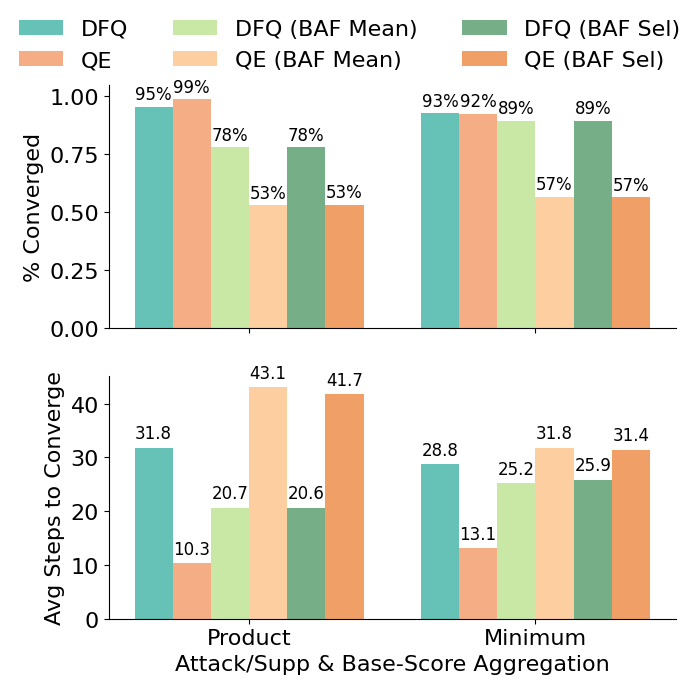

In [15]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import re

# ── define files ────────────────────────────────────────────────────
scenario_files = [
    ("Product","",             "convergence_results_to10m_nf_atm_e2_d5_s5000_randinitall_prod.pkl"),
    ("Minimum","",             "convergence_results_to10m_nf_atm_e2_d5_s5000_randinitall_min.pkl"),
    ("Product"," (BAF Mean)", "convergence_results_to10m_nf_atm_e3_d5_s5000_randinitall_prod_mean.pkl"),
    ("Minimum"," (BAF Mean)", "convergence_results_to10m_nf_atm_e3_d5_s5000_randinitall_min_mean.pkl"),
    ("Product"," (BAF Sel)",  "convergence_results_to10m_nf_atm_e3_d5_s5000_randinitall_prod_sel.pkl"),
    ("Minimum"," (BAF Sel)",  "convergence_results_to10m_nf_atm_e3_d5_s5000_randinitall_min_sel.pkl"),
]

def load_overall_stats(path, suffix=""):
    runs = pickle.load(open(path, "rb"))
    good = [r for r in runs if not r.get("timeout", False)]
    by_model = defaultdict(list)

    # 1) normalise r["model"] by collapsing spaces
    for r in good:
        raw = r["model"]
        norm = " ".join(raw.split())    # turns "QE      (BAF)" -> "QE (BAF)"
        by_model[norm].append(r)

    # 2) compute rate+time per model
    stats = {}
    for m, rs in by_model.items():
        N     = len(rs)
        convN = sum(1 for r in rs if r.get("global_converged"))
        rate  = convN/N if N else 0.0

        avg_times = []
        for r in rs:
            ct = r.get("convergence_time")
            if isinstance(ct, dict):
                vals = [v for v in ct.values() if v is not None]
                if vals: avg_times.append(sum(vals)/len(vals))
            elif isinstance(ct,(int,float)):
                avg_times.append(ct)
        mean_time = sum(avg_times)/len(avg_times) if avg_times else 0.0

        stats[m] = (rate, mean_time)

    # 3) if this is one of the BAF‐pickles, remap "(BAF)" keys to include your suffix
    if suffix:
        to_add = {}
        for old in list(stats):
            if old.endswith("(BAF)"):
                base = old[:-len("(BAF)")].strip()    # "DF-QuAD"
                new  = f"{base}{suffix}"              # e.g. "DF-QuAD (BAF Mean)"
                to_add[new] = stats.pop(old)
        stats.update(to_add)

    print(f"\nLoaded {path!r}  (suffix={suffix!r})")
    print(" → models:", sorted(stats.keys()))
    return stats


# load everything
raw_stats = {}
for agg, suffix, pkl in scenario_files:
    raw_stats[(agg,suffix)] = load_overall_stats(pkl, suffix)

# canonical model order
models = [
    "DF-QuAD", "QE",
    "DF-QuAD (BAF Mean)", "QE (BAF Mean)",
    "DF-QuAD (BAF Sel)",  "QE (BAF Sel)"
]
setaggs = ["Product","Minimum"]

# build rate/time tables
conv_rates = { agg: [] for agg in setaggs }
conv_times = { agg: [] for agg in setaggs }

for agg in setaggs:
    for m in models:
        # figure out which suffix slot this model lives in
        suffix = ""
        if m.endswith("(BAF Mean)"): suffix = " (BAF Mean)"
        elif m.endswith("(BAF Sel)"): suffix = " (BAF Sel)"

        rate, tm = raw_stats[(agg,suffix)].get(m, (0.0, 0.0))
        conv_rates[agg].append(rate)
        conv_times[agg].append(tm)

# ── plotting ───────────────────────────────────────────────────────────────
n_models = len(models)
width    = 0.8 / n_models
x        = np.arange(len(setaggs))

colors = {
    'DF-QuAD':            "#009988",   # dark teal
    'QE':                 "#EE7733",   # dark orange

    # two distinct greens for the BAF traces
    'DF-QuAD (BAF Mean)': "#A6D96A",   # light olive-green
    'DF-QuAD (BAF Sel)':  "#1B7837",   # deep forest-green

    # two distinct orange/yellows for the BAF traces
    'QE (BAF Mean)':      "#FDAE61",   # warm butter-yellow
    'QE (BAF Sel)':       "#E66101",   # burnt-orange
}

fig, (ax_rate, ax_time) = plt.subplots(2,1, figsize=(7,7), sharex=True)

# convergence rates
for i,m in enumerate(models):
    off = (i - (n_models-1)/2)*width
    vals = [conv_rates[agg][i] for agg in setaggs]
    ax_rate.bar(x+off, vals, width, color=colors[m], label=m, alpha=0.6)
    for xi,v in zip(x, vals):
        ax_rate.text(xi+off, v+0.015, f"{100*v:.0f}%",  
                     ha="center", va="bottom", fontsize=12)

ax_rate.set_ylabel("% Converged")
ax_rate.set_ylim(0,1.05)
ax_rate.spines['top'].set_visible(False)
ax_rate.spines['right'].set_visible(False)

# convergence times
for i,m in enumerate(models):
    off = (i - (n_models-1)/2)*width
    vals = [conv_times[agg][i] for agg in setaggs]
    ax_time.bar(x+off, vals, width, color=colors[m], label=m, alpha=0.6)
    for xi,v in zip(x, vals):
        ax_time.text(xi+off, v+1, f"{v:.1f}",  
                     ha="center", va="bottom", fontsize=12)

ax_time.set_ylabel("Avg Steps to Converge")
ax_time.set_xticks(x)
ax_time.set_xticklabels(setaggs)
ax_time.set_xlabel("Attack/Supp & Base-Score Aggregation")
ax_time.spines['top'].set_visible(False)
ax_time.spines['right'].set_visible(False)

# two‐row legend
handles, labels = ax_time.get_legend_handles_labels()
labels = [lbl.replace("DF-QuAD", "DFQ") for lbl in labels]

fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False)

plt.tight_layout(rect=[0,0,1,0.92])
plt.show()


## Changes by ABAF for all instances

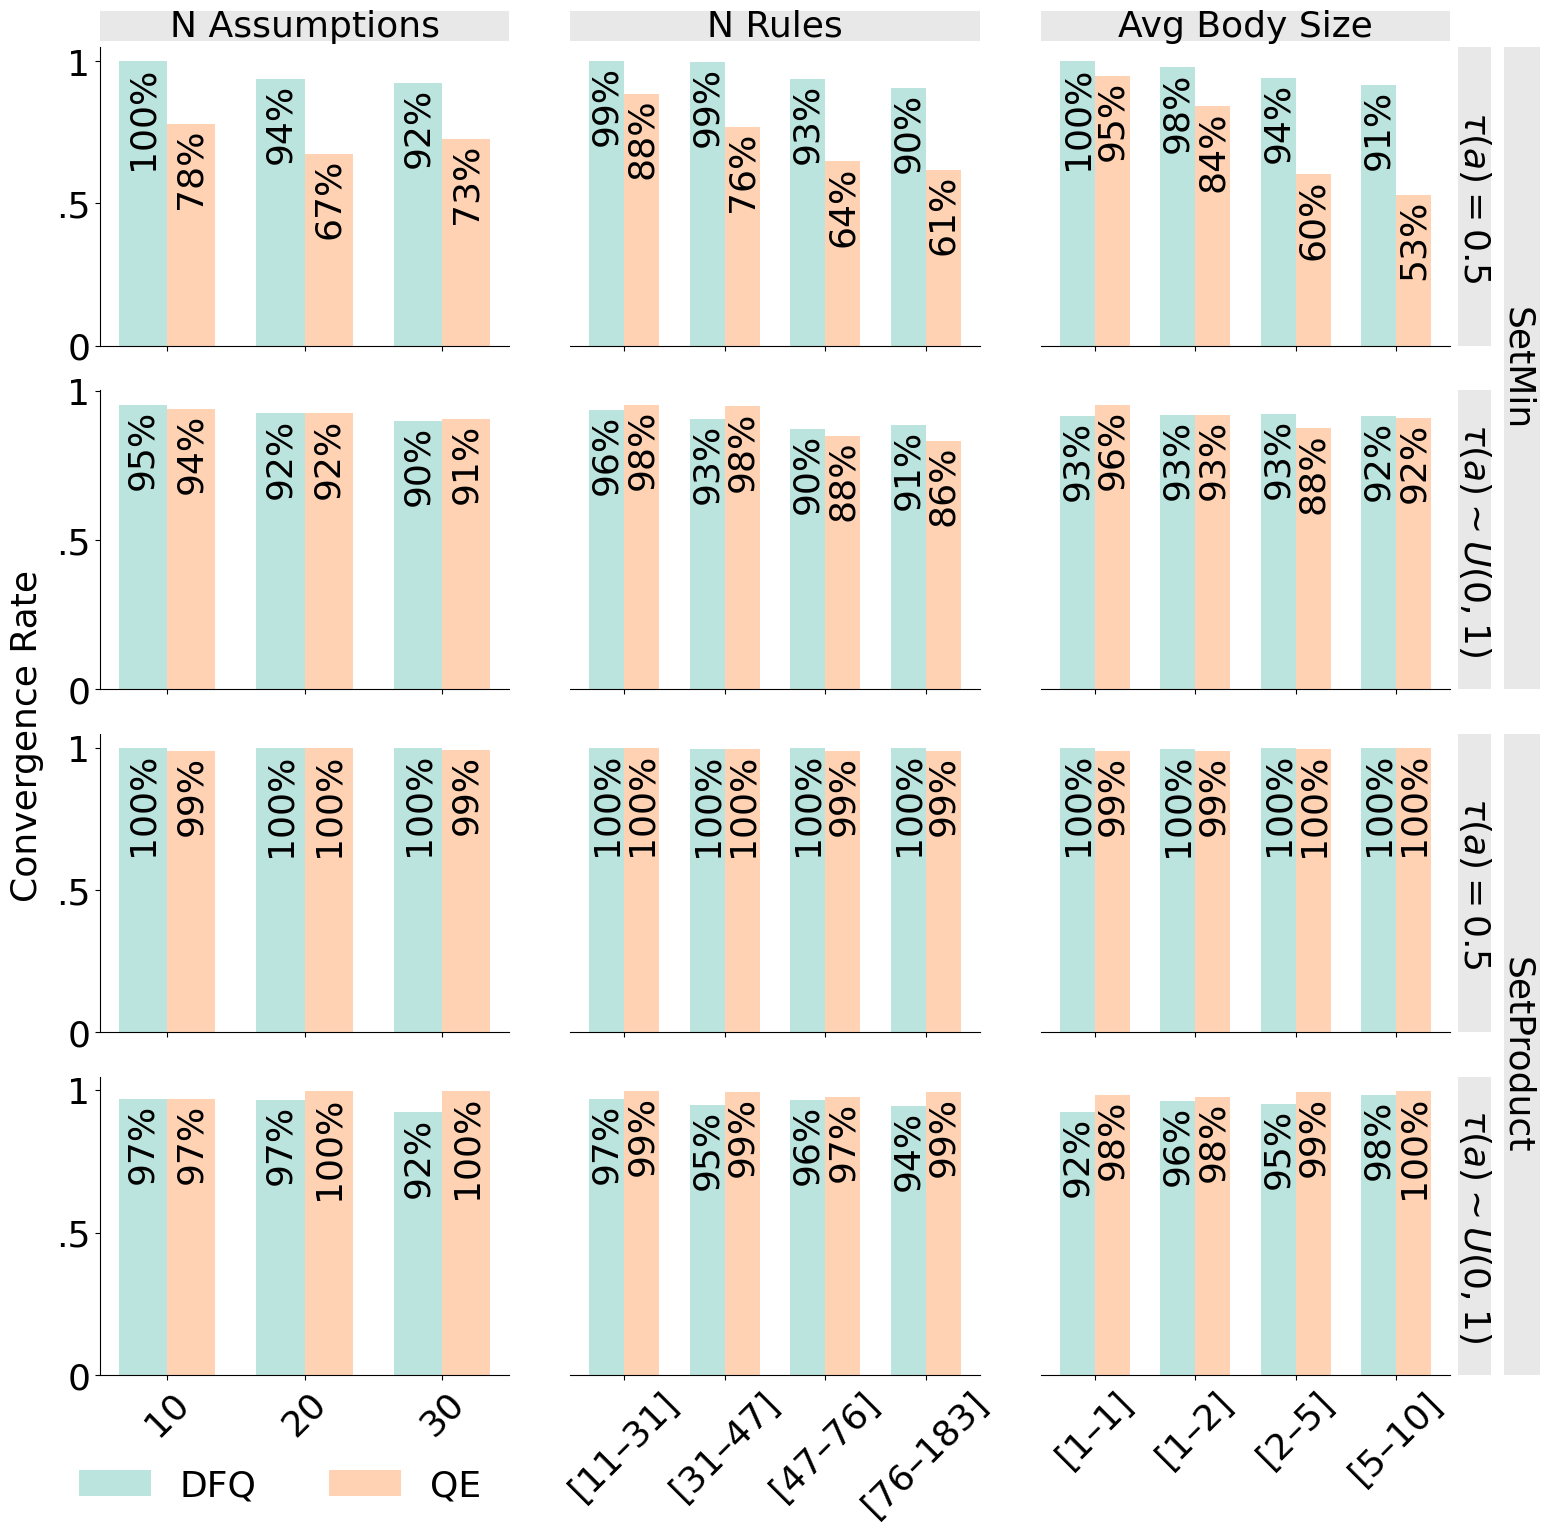

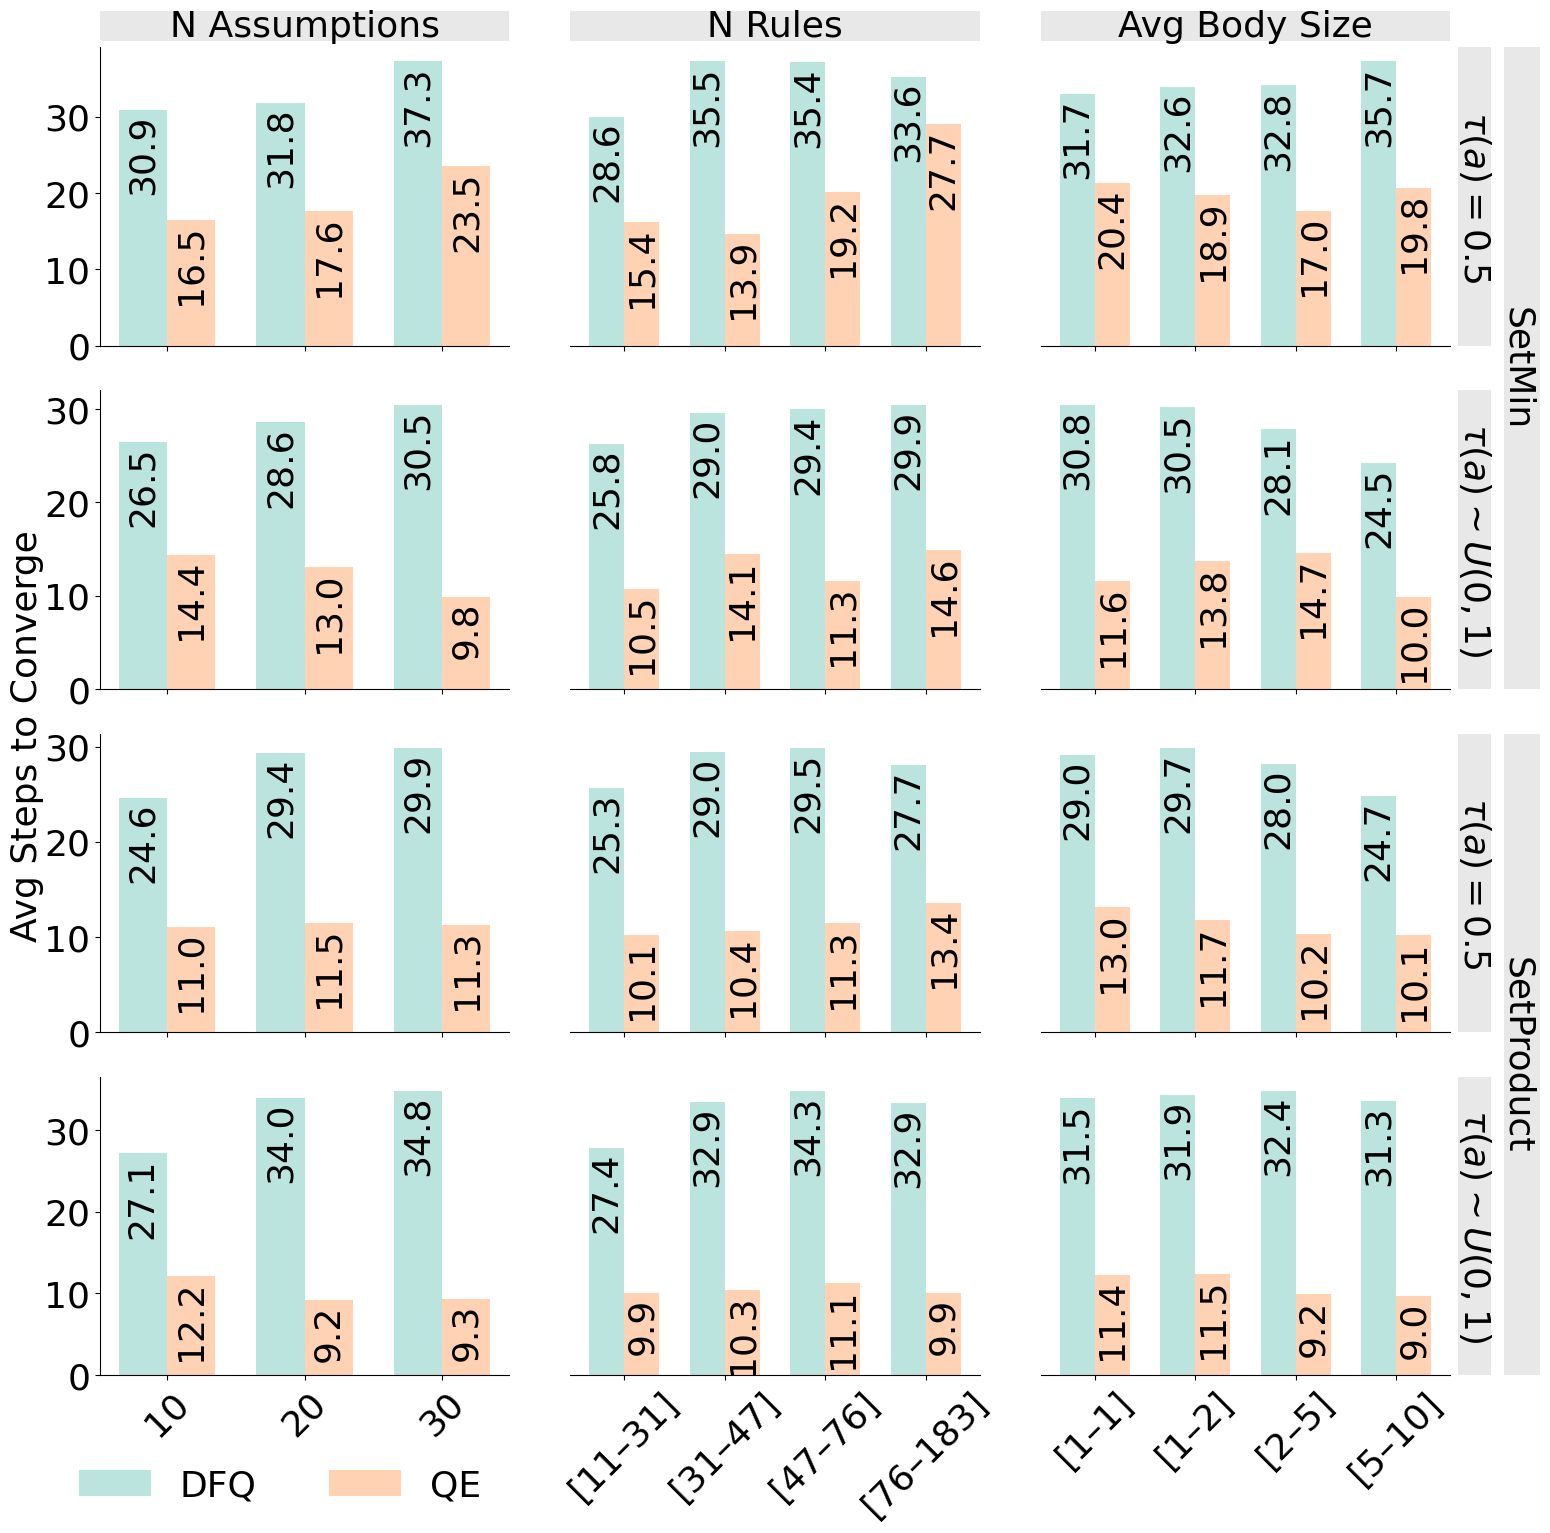

In [7]:
import warnings

# ── QUIET ONLY THOSE WARNINGS ─────────────────────────────────────────────
warnings.filterwarnings(
    "ignore",
    message="Mean of empty slice\\."                # numpy empty-slice
)
warnings.filterwarnings(
    "ignore",
    message="invalid value encountered in scalar divide"
)
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,                         # pandas downcast on fillna/fill*
    message=".*downcast.*fillna.*"
)
# ────────────────────────────────────────────────────────────────────────────

import pickle
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pandas.api.types import CategoricalDtype

# ── CONFIG ────────────────────────────────────────────────────────────────
ABA_FOLDER = Path("../data_generation/abaf/")

SCENARIO_FILES = {
    "SetMin": [
        ("Fixed",  "convergence_results_to10m_nf_atm_e2_d5_s5000_min.pkl"),
        ("Random", "convergence_results_to10m_nf_atm_e2_d5_s5000_randinitall_min.pkl"),
    ],
    "SetProduct": [
        ("Fixed",  "convergence_results_to10m_nf_atm_e2_d5_s5000_prod.pkl"),
        ("Random", "convergence_results_to10m_nf_atm_e2_d5_s5000_randinitall_prod.pkl"),
    ],
}

SCENARIOS = [
    (f"{group} – {suffix}", path)
    for group, entries in SCENARIO_FILES.items()
    for suffix, path in entries
]

META_COLS = ["num_assumptions_file", "num_rules_file", "avg_body_size_file"]
COL_DISPLAY = {
    "num_assumptions_file": "N Assumptions",
    "num_rules_file":       "N Rules",
    "avg_body_size_file":   "Avg Body Size"
}
Q        = 4
FONTSIZE = 26

tau_map = {
    "Fixed":     r"$\tau(a)=0.5$",
    "Random":    r"$\tau(a)\sim U(0,1)$"
}

def build_file_meta(folder: Path) -> pd.DataFrame:
    rec = {}
    for p in sorted(folder.glob("*.aba")):
        lines   = p.read_text().splitlines()
        assumps = [l for l in lines if l.startswith("a ")]
        rules   = [l for l in lines if l.startswith("r ")]
        bodies  = [r.split()[2:] for r in rules]
        rec[p.stem] = {
            "num_assumptions_file": len(assumps),
            "num_rules_file":       len(rules),
            "avg_body_size_file":   (sum(len(b) for b in bodies)/len(bodies)) if bodies else 0.0,
        }
    return pd.DataFrame.from_dict(rec, orient="index")

meta = build_file_meta(ABA_FOLDER)

def _avg_time(ct):
    """Safe average: no empty-slice warnings."""
    if isinstance(ct, dict):
        vals = [v for v in ct.values() if v is not None]
        return sum(vals)/len(vals) if vals else 0.0
    elif isinstance(ct, (int, float)):
        return ct
    return 0.0

# ── LOAD & MERGE ALL SCENARIOS ─────────────────────────────────────────────
frames = []
for label, pkl_path in SCENARIOS:
    runs = pickle.load(open(pkl_path, "rb"))
    df   = pd.DataFrame(runs)
    df   = df[df["timeout"] == False].copy()
    df["stem"] = df["file"].str.replace(r"\.aba$", "", regex=True)
    df = df.merge(meta, left_on="stem", right_index=True, how="left")
    df["conv_time_avg"] = df["convergence_time"].apply(_avg_time)
    df["scenario"] = label
    frames.append(df)

all_df = pd.concat(frames, ignore_index=True)

# ── BUCKET METADATA COLUMNS ────────────────────────────────────────────────
for col in META_COLS:
    nuniq    = all_df[col].nunique()
    bucket   = col + "_bucket"
    if nuniq <= Q:
        all_df[bucket] = all_df[col].astype(str)
    else:
        all_df[bucket] = pd.qcut(all_df[col], q=min(Q, nuniq), duplicates="drop")

# ── PLOTTING FUNCTION ─────────────────────────────────────────────────────
def plot_metric(metric, title, ylabel, fmt_tick):
    n_row, n_col = len(SCENARIOS), len(META_COLS)
    fig, axes = plt.subplots(n_row, n_col,
                             figsize=(6*n_col, 4*n_row),
                             sharey=False)
    fig.subplots_adjust(left=0.15, right=0.90,
                        top=0.88, bottom=0.05,
                        hspace=0.15, wspace=0.15)

    legend_handles = legend_labels = None

    for i, (scenario, _) in enumerate(SCENARIOS):
        group, bs = scenario.split(" – ")
        sub = all_df[all_df["scenario"] == scenario]

        for j, col in enumerate(META_COLS):
            ax = axes[i][j]
            bc = col + "_bucket"

            # categories
            dtype = sub[bc].dtype
            if isinstance(dtype, CategoricalDtype):
                cats     = sub[bc].cat.categories
                labels_x = [f"[{int(iv.left)}–{int(iv.right)}]" for iv in cats]
            else:
                cats     = sorted(sub[bc].unique())
                labels_x = [str(c) for c in cats]

            # group with observed=False
            grp = (sub
                   .groupby([bc, "model"], observed=False)
                   .agg(runs=("timeout","count"),
                        n_conv=("global_converged","sum"),
                        avg=("conv_time_avg","mean")))

            # silence only the pandas downcast warning
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", FutureWarning)
                piv = grp.unstack("model").fillna(0)

            if metric == "rate":
                vals = (piv["n_conv"] / piv["runs"]).reindex(cats, fill_value=0)
            else:
                vals = piv["avg"].reindex(cats, fill_value=np.nan)

            # clean up column names
            vals.columns = (vals.columns
                             .to_series()
                             .str.replace(r"\s*\(BAF\)",  "", regex=True)
                             .str.replace(r"\s*\(BSAF\)", "", regex=True)
                             .str.strip())
            vals = vals.loc[:, ~vals.columns.duplicated()]

            qad = vals["DF-QuAD"].to_numpy()
            qe  = vals["QE"].to_numpy()

            teal, orange = "#8dd3c7", "#ffb482"
            x = np.arange(len(cats))
            w = 0.35

            b1 = ax.bar(x - w/2, qad, w, label="DfQ", alpha=0.6, color=teal)
            b2 = ax.bar(x + w/2, qe,  w, label="QE",  alpha=0.6, color=orange)

            # ── ANNOTATIONS VIA REAL BBOX CHECK ────────────────────────────────
            ax.set_ylim(bottom=0)
            fig = ax.figure
            pix_per_pt = fig.dpi / 72.0
            off_pts = 3
            pix_off = off_pts * pix_per_pt
            zero_disp = ax.transData.transform((0, 0))[1]
            fig.canvas.draw()
            renderer = fig.canvas.get_renderer()

            for bar in list(b1) + list(b2):
                h    = bar.get_height()
                xcen = bar.get_x() + bar.get_width() / 2
                lbl  = fmt_tick(h)

                text = ax.annotate(
                    lbl,
                    xy=(xcen, h),
                    xytext=(0, -off_pts),
                    textcoords="offset points",
                    ha="center", va="top",
                    rotation=90,
                    fontsize=FONTSIZE
                )
                bbox = text.get_window_extent(renderer=renderer)
                if bbox.y0 < zero_disp:
                    text.remove()
                    disp0 = ax.transData.transform((0, 0))
                    disp1 = ax.transData.transform((0, 1))
                    data_per_pix = 1.0 / (disp1[1] - disp0[1])
                    off_data   = pix_off * data_per_pix
                    ax.text(
                        xcen,
                        h + off_data,
                        lbl,
                        ha="center", va="bottom",
                        rotation=90, fontsize=FONTSIZE,
                    )

            ax.set_xticks(x)
            if i == n_row - 1:
                ax.set_xticklabels(labels_x, rotation=45, fontsize=FONTSIZE)
            else:
                ax.set_xticklabels([])

            ax.tick_params(axis='y', labelsize=FONTSIZE)
            if j != 0:
                ax.yaxis.set_visible(False)
                ax.spines['left'].set_visible(False)
            else:
                if metric == "rate":
                    ax.set_yticks([0, 0.5, 1])
                    ax.set_yticklabels(["0", ".5", "1"], fontsize=FONTSIZE)

            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            if legend_handles is None and i == 0 and j == n_col - 1:
                legend_handles = [b1, b2]
                legend_labels  = ["DFQ", "QE"]

        # right τ‐bar
        ax_side = axes[i][-1]
        ax_side.add_patch(
            patches.Rectangle((1.02, 0), 0.08, 1,
                              transform=ax_side.transAxes,
                              facecolor="lightgrey", edgecolor="none",
                              alpha=0.5, clip_on=False)
        )
        ax_side.text(
            1.02 + 0.08/2, 0.5,
            tau_map[bs],
            transform=ax_side.transAxes,
            ha='center', va='center', rotation=-90,
            fontsize=FONTSIZE
        )

    # grey column headers
    box_y, box_h = 1.00 + 0.02, 0.10
    for j in range(n_col):
        ax_top = axes[0][j]
        ax_top.add_patch(
            patches.Rectangle((0, box_y), 1, box_h,
                              transform=ax_top.transAxes,
                              facecolor="lightgrey",
                              edgecolor="none", alpha=0.5, clip_on=False)
        )
        ax_top.text(
            0.5, box_y + box_h/2,
            COL_DISPLAY[META_COLS[j]],
            transform=ax_top.transAxes,
            ha='center', va='center', fontsize=FONTSIZE
        )

    # group labels on right
    for group, rows in [("SetMin", [0,1]), ("SetProduct", [2,3])]:
        top    = axes[rows[0]][-1].get_position().x0 + axes[rows[0]][-1].get_position().width
        bottom = axes[rows[-1]][-1].get_position().x0 + axes[rows[-1]][-1].get_position().width
        y_top  = axes[rows[0]][-1].get_position().y1
        y_bot  = axes[rows[-1]][-1].get_position().y0
        height = y_top - y_bot

        fig.patches.append(
            patches.Rectangle(
                (top + 0.03, y_bot),
                0.02, height,
                transform=fig.transFigure,
                facecolor="lightgrey",
                edgecolor="none", alpha=0.5
            )
        )
        fig.text(
            top - 0.0625 + 0.2/2,
            y_bot + height/2,
            group,
            transform=fig.transFigure,
            ha='center', va='center', rotation=-90,
            fontsize=FONTSIZE
        )

    # legend & titles
    fig.legend(legend_handles, legend_labels,
               loc='lower left', bbox_to_anchor=(0.12, -0.05),
               frameon=False, fontsize=FONTSIZE, ncol=2)
    fig.suptitle(title, y=0.96, fontsize=FONTSIZE)
    fig.supylabel(ylabel, x=0.1, y=0.45, fontsize=FONTSIZE)

    plt.show()

# ── DRAW THE TWO PLOTS ───────────────────────────────────────────────────
plot_metric(
    metric="rate",
    title="",
    ylabel="Convergence Rate",
    fmt_tick=lambda v: f"{100*v:.0f}%"
)
plot_metric(
    metric="time",
    title="",
    ylabel="Avg Steps to Converge",
    fmt_tick=lambda v: f"{v:.1f}"
)


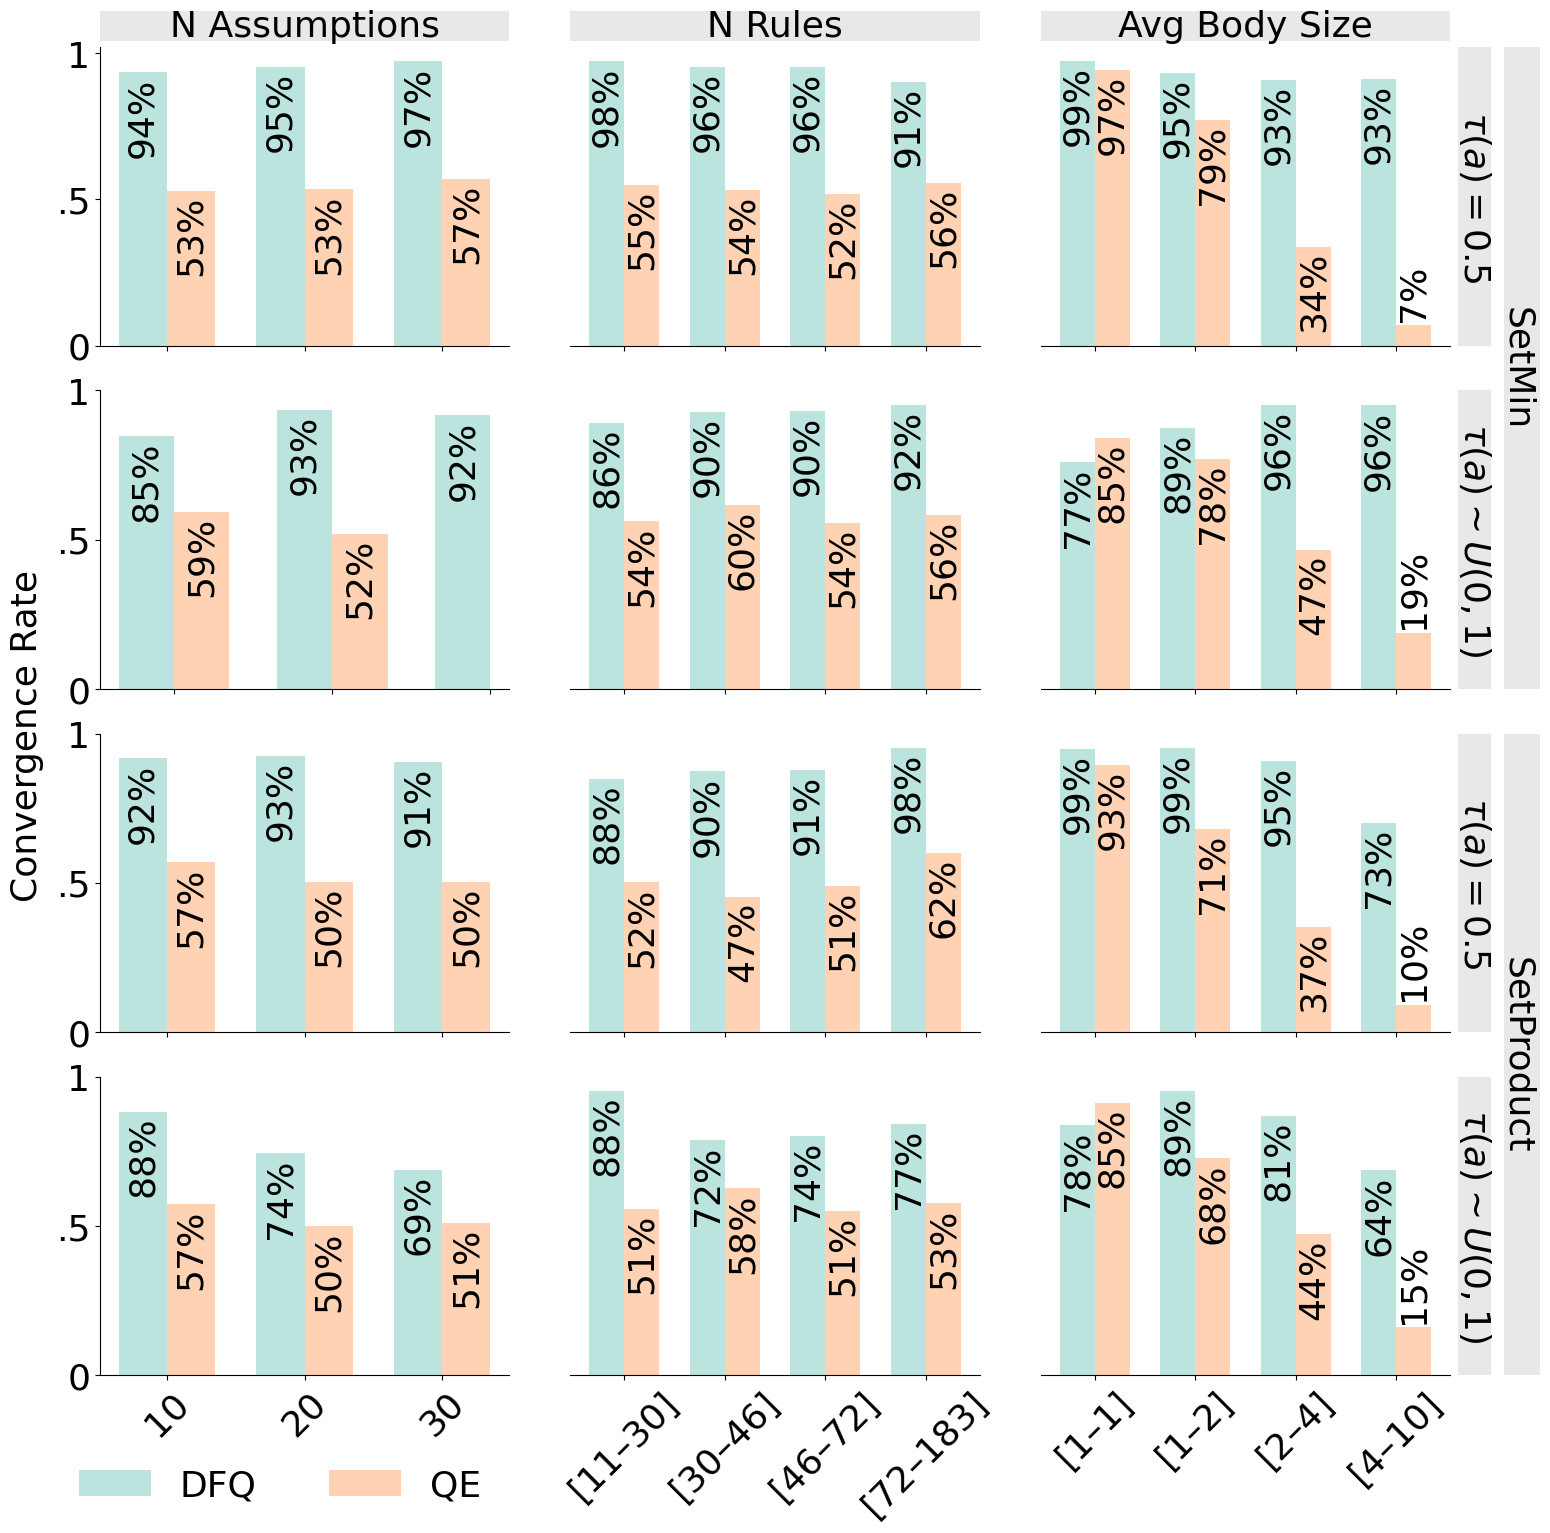

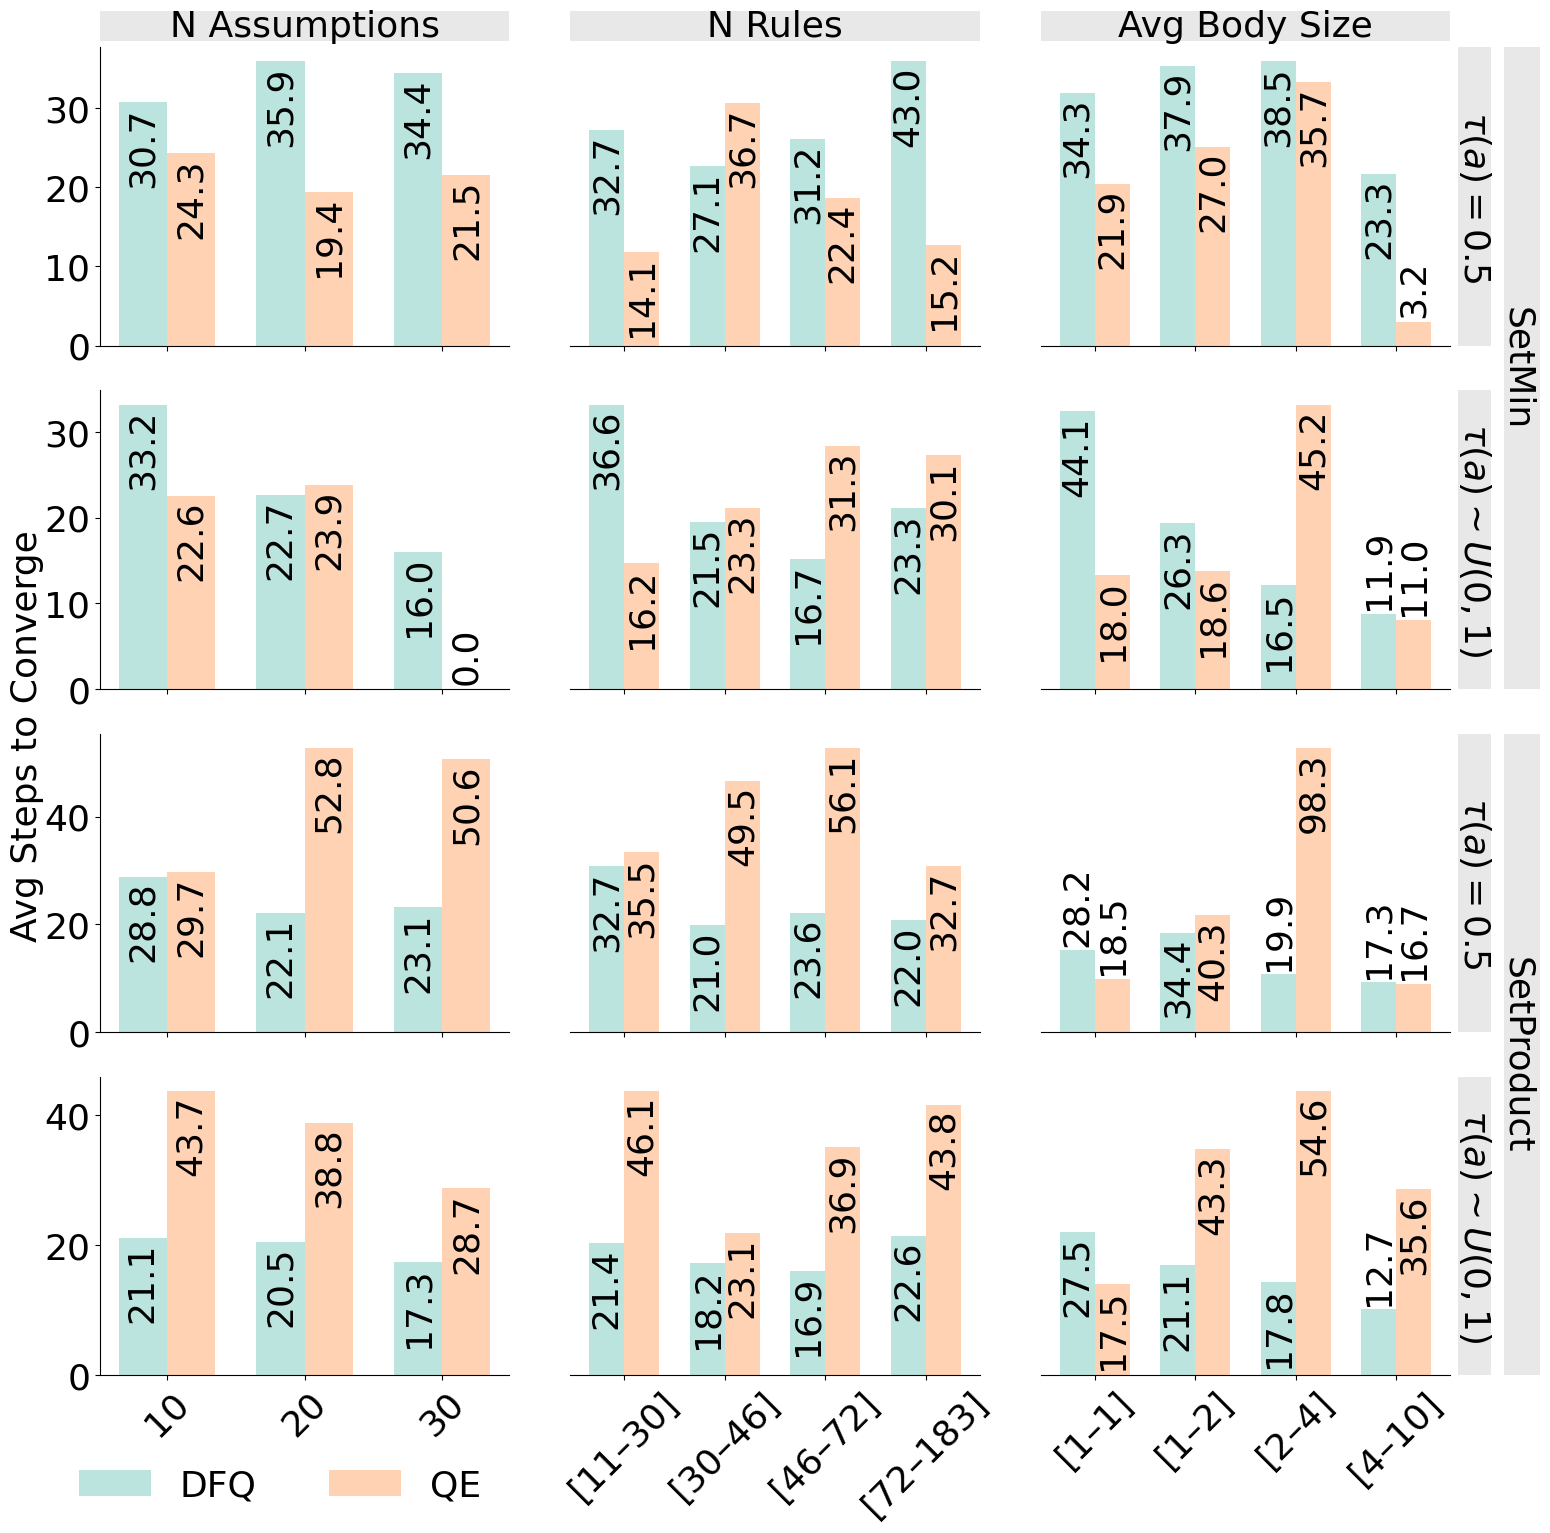

In [8]:
import pickle
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# ── CONFIG ────────────────────────────────────────────────────────────────
ABA_FOLDER = Path("../data_generation/abaf/")

# group the two runs per framework
SCENARIO_FILES = {
    "SetMin": [
        ("Fixed",  "convergence_results_to10m_nf_atm_e3_d5_s5000_min_mean.pkl"),
        ("Random", "convergence_results_to10m_nf_atm_e3_d5_s5000_randinitall_min_mean.pkl"),
    ],
    "SetProduct": [
        ("Fixed",  "convergence_results_to10m_nf_atm_e3_d5_s5000_prod_mean.pkl"),
        ("Random", "convergence_results_to10m_nf_atm_e3_d5_s5000_randinitall_prod_mean.pkl"),
    ],
}

SCENARIOS = [
    (f"{group} – {suffix}", path)
    for group, entries in SCENARIO_FILES.items()
    for suffix, path in entries
]

META_COLS = ["num_assumptions_file", "num_rules_file", "avg_body_size_file"]
COL_DISPLAY = {
    "num_assumptions_file": "N Assumptions",
    "num_rules_file":       "N Rules",
    "avg_body_size_file":   "Avg Body Size"
}
Q        = 4
FONTSIZE = 26

tau_map = {
    "Fixed":     r"$\tau(a)=0.5$",
    "Random":    r"$\tau(a)\sim U(0,1)$"
}

def build_file_meta(folder: Path) -> pd.DataFrame:
    rec = {}
    for p in sorted(folder.glob("*.aba")):
        lines   = p.read_text().splitlines()
        assumps = [l for l in lines if l.startswith("a ")]
        rules   = [l for l in lines if l.startswith("r ")]
        bodies  = [r.split()[2:] for r in rules]
        rec[p.stem] = {
            "num_assumptions_file": len(assumps),
            "num_rules_file":       len(rules),
            "avg_body_size_file":   (sum(len(b) for b in bodies)/len(bodies)) if bodies else 0.0,
        }
    return pd.DataFrame.from_dict(rec, orient="index")

meta = build_file_meta(ABA_FOLDER)

def _avg_time(ct):
    """Safe average: no empty-slice warnings."""
    if isinstance(ct, dict):
        vals = [v for v in ct.values() if v is not None]
        return sum(vals)/len(vals) if vals else 0.0
    elif isinstance(ct, (int, float)):
        return ct
    return 0.0

# ── LOAD & MERGE ALL SCENARIOS ─────────────────────────────────────────────
frames = []
for label, pkl_path in SCENARIOS:
    runs = pickle.load(open(pkl_path, "rb"))
    df   = pd.DataFrame(runs)
    df   = df[df["timeout"] == False].copy()
    df["stem"] = df["file"].str.replace(r"\.aba$", "", regex=True)
    df = df.merge(meta, left_on="stem", right_index=True, how="left")
    df["conv_time_avg"] = df["convergence_time"].apply(_avg_time)
    df["scenario"] = label
    frames.append(df)

all_df = pd.concat(frames, ignore_index=True)

# ── BUCKET METADATA COLUMNS ────────────────────────────────────────────────
for col in META_COLS:
    nuniq    = all_df[col].nunique()
    bucket   = col + "_bucket"
    if nuniq <= Q:
        all_df[bucket] = all_df[col].astype(str)
    else:
        all_df[bucket] = pd.qcut(all_df[col], q=min(Q, nuniq), duplicates="drop")

# draw the two plots
plot_metric(
    metric="rate",
    title="",
    ylabel="Convergence Rate",
    fmt_tick=lambda v: f"{100*v:.0f}%"
)
plot_metric(
    metric="time",
    title="",
    ylabel="Avg Steps to Converge",
    fmt_tick=lambda v: f"{v:.1f}"
)

## Df-QuAD Plot for 1000 and 5000 Steps

[CACHE HIT]   nf_atm_s40_n0.2_a0.5_r4_b8_0.aba
{'a19': False, 'a18': False, 'a7': True, 'a13': False, 'a2': False, 'a15': True, 'a3': True, 'a5': False, 'a17': True, 'a14': False, 'a8': False, 'a12': True, 'a16': True, 'a6': False, 'a9': False, 'a4': False, 'a11': True, 'a10': False, 'a1': False, 'a0': True}
DF-QuAD - Proportion of converged assumptions: 40.0%
DF-QuAD - Some are still oscillating or drifting.
DF-QuAD - The assumptions that are not converged are: ['a19', 'a18', 'a13', 'a2', 'a5', 'a14', 'a8', 'a6', 'a9', 'a4', 'a10', 'a1']
{'a19': True, 'a18': True, 'a7': True, 'a13': True, 'a2': True, 'a15': True, 'a3': True, 'a5': True, 'a17': True, 'a14': True, 'a8': True, 'a12': True, 'a16': True, 'a6': True, 'a9': True, 'a4': True, 'a11': True, 'a10': True, 'a1': True, 'a0': True}
QE - Proportion of converged assumptions: 100.0%
QE - All assumptions have stabilized in the last 5 steps.


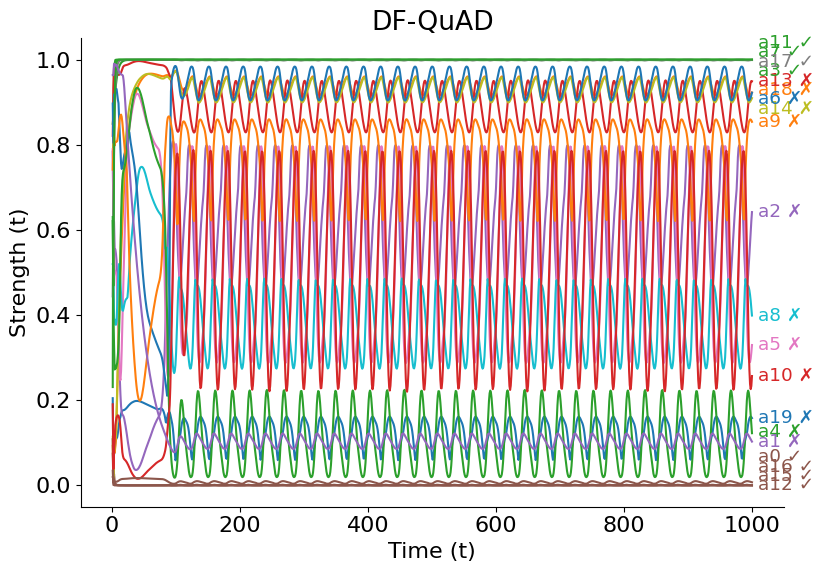

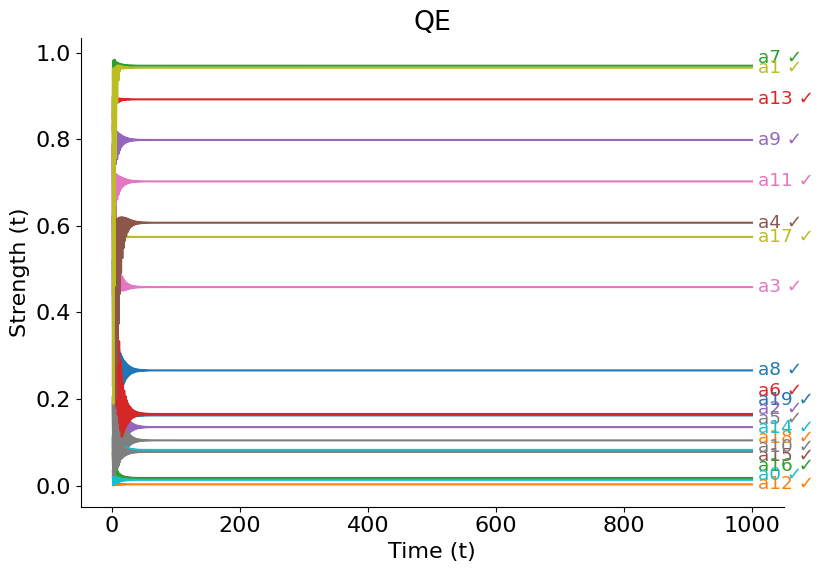

In [18]:
TIME_STEPS = 1000 ### Change this to 5000 for the additional plot


from tqdm import tqdm
import sys
sys.path.append("../")
from pathlib import Path
import random
import pickle

from BAG import BAG

from plotting import strengthplot

from ABAF import ABAF
from ABAF.Assumption import Assumption
from BSAF import BSAF
from BSAF.Argument import Argument
from semantics.bsafDiscreteModular import DiscreteModular
from semantics.modular.EulerBasedInfluence import EulerBasedInfluence
from semantics.modular.LinearInfluence import LinearInfluence
from semantics.modular.ProductAggregation import ProductAggregation
from semantics.modular.SetProductAggregation import SetProductAggregation
from semantics.modular.SetMinAggregation import SetMinAggregation
from semantics.modular import SumAggregation
from semantics.modular import QuadraticMaximumInfluence

EPSILON = 1e-3
DELTA   = 5
VERBOSE = False
BASE_SCORES     = 'random' # 'random' or '' (empty==DEFAULT_WEIGHTS)
CACHE_OVERRIDE  = False # set to True to override existing cache files
INPUT_DIR       = Path("../data_generation/abaf/").resolve()
CACHE_DIR       = Path(INPUT_DIR,"bsaf_frameworks")
CACHE_DIR.mkdir(exist_ok=True)
INPUT_DIR.mkdir(exist_ok=True)

FONTSIZE = 16
plt.rcParams.update({'font.size': FONTSIZE})

def load_or_build_bsaf(aba_path: Path):
    """
    Caches ABAF.to_bsaf() on disk under bsaf_cache/<stem>.bsaf.pkl.
    If CACHE_OVERRIDE is True, always rebuild (even if the cache file exists).
    """
    cache_file = CACHE_DIR / (aba_path.stem + f"{BASE_SCORES}.bsaf.pkl")

    # if cache exists and we're not overriding, just load
    if cache_file.exists() and not CACHE_OVERRIDE:
        print(f"[CACHE HIT]   {aba_path.name}", flush=True)
        with open(cache_file, "rb") as f:
            return pickle.load(f)

    # otherwise we're (re)building
    if cache_file.exists() and CACHE_OVERRIDE:
        print(f"[OVERRIDE]    {aba_path.name}  (rebuilding cache)", flush=True)
    else:
        print(f"[BUILDING]    {aba_path.name}", flush=True)

    # build & cache
    abaf = ABAF(path=str(aba_path))
    bsaf = abaf.to_bsaf()
    with open(cache_file, "wb") as f:
        pickle.dump(bsaf, f)
    return bsaf

paths_to_plot = [
    "../data_generation/abaf/nf_atm_s40_n0.2_a0.5_r4_b8_0.aba" ## Second row in the main paper plot

#     "../data_generation/abaf/nf_atm_s20_n0.1_a0.5_r8_b2_7.aba", ## DF-QuAD wins
#     "../data_generation/abaf/nf_atm_s60_n0.05_a0.5_r8_b4_8.aba", ## QE wins
#     "../data_generation/abaf/nf_atm_s20_n0.2_a0.5_r8_b4_4.aba", ## Neither Converges
#     "../data_generation/abaf/nf_atm_s20_n0.05_a0.5_r8_b8_5.aba", ## QE wins FLAT
]

# random.seed(42)
for path in paths_to_plot:

    # abaf = ABAF(path=path, weight_fn=lambda: random.uniform(0.0, 1.0))

    # print(abaf)
    # print("Flat:", not abaf.non_flat)

    # print(f"Number of Assumptions: {len(abaf.assumptions)}")
    # print(f"Number of Rules: {len(abaf.rules)}")

    Assumption.reset_identifiers()
    Argument.reset_identifiers()

    bsaf = load_or_build_bsaf(Path(path))


    # 2) re-load ABAF only to count size-stats and update the initial strengths
    abaf = ABAF(path=str(path), 
                weight_fn=lambda: random.uniform(0.0, 1.0) if BASE_SCORES == "random" else None)
    num_assumptions = len(abaf.assumptions)
    num_rules       = len(abaf.rules)
    num_sentences   = len(abaf.sentences)

    # 3) collect initial strengths
    initial_strengths = { a.name: a.initial_weight for a in abaf.assumptions}

    ## update the initial strengths in the BSAF
    for a in bsaf.assumptions:
        if a.name in initial_strengths:
            a.initial_weight = initial_strengths[a.name]
        else:
            raise ValueError(f"Assumption {a.name} not found in initial strengths")

    # print(bsaf)

    model = DiscreteModular(BSAF=bsaf, aggregation=ProductAggregation(), 
                            influence=LinearInfluence(conservativeness=1), 
                            # set_aggregation=SetProductAggregation()
                            set_aggregation=SetMinAggregation()
                            )

    model.solve(TIME_STEPS, generate_plot=True, verbose=VERBOSE)

    strengthplot(model, delta=DELTA, epsilon=EPSILON,
                title="DF-QuAD", wide=10, tall=6)

    # check convergence over the last 5 iterations, with ε=1e-3
    per_arg = model.has_converged(epsilon=EPSILON, last_n=DELTA)
    print(per_arg)  
    # e.g. {'a0': True, 'a1': False, ...}
    prop_conv       = (sum(per_arg.values()) / len(per_arg)) if len(per_arg) else 0.0
    print(f"DF-QuAD - Proportion of converged assumptions: {prop_conv:.1%}")

    if model.is_globally_converged(epsilon=EPSILON, last_n=DELTA):
        print("DF-QuAD - All assumptions have stabilized in the last 5 steps.")
    else:
        print("DF-QuAD - Some are still oscillating or drifting.")
        print(f"DF-QuAD - The assumptions that are not converged are: {[a for a, b in per_arg.items() if not b]}")


    model2 = DiscreteModular(BSAF=bsaf, aggregation=SumAggregation(), 
                            influence=QuadraticMaximumInfluence(conservativeness=1), 
                            # set_aggregation=SetProductAggregation()
                            set_aggregation=SetMinAggregation()
                            )

    model2.solve(TIME_STEPS, generate_plot=True, verbose=VERBOSE)

    strengthplot(model2, delta=DELTA, epsilon=EPSILON,
                title="QE", wide=10, tall=6)

    # check convergence over the last 5 iterations, with ε=1e-3
    per_arg = model2.has_converged(epsilon=EPSILON, last_n=DELTA)
    print(per_arg)
    # e.g. {'a0': True, 'a1': False, ...}
    prop_conv       = (sum(per_arg.values()) / len(per_arg)) if len(per_arg) else 0.0
    print(f"QE - Proportion of converged assumptions: {prop_conv:.1%}")


    if model2.is_globally_converged(epsilon=EPSILON, last_n=DELTA):
        print("QE - All assumptions have stabilized in the last 5 steps.")
    else:
        print("QE - Some are still oscillating or drifting.")
        print(f"QE - The assumptions that are not converged are: {[a for a, b in per_arg.items() if not b]}")
